# MIE1624 Final Project

## part 1: Sentiment modeling

import libraries and read data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import random
import numpy as np
import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold

import nltk
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk.stem import *
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')



[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
data = pd.read_csv("/sentiment_analysis.csv")
data # label 0-negative; 1-positive

ID                                               text  label
0       7.680980e+17  Josh Jenkins is looking forward to TAB Breeder...      1
1       7.680980e+17  RT @MianUsmanJaved: Congratulations Pakistan o...      1
2       7.680980e+17  RT @PEPalerts: This September, @YESmag is taki...      1
3       7.680980e+17  RT @david_gaibis: Newly painted walls, thanks ...      1
4       7.680980e+17  RT @CedricFeschotte: Excited to announce: as o...      1
...              ...                                                ...    ...
550386  8.046170e+17  @goddesses_o I can't stop watching her...mm. M...      0
550387  8.046180e+17  Poor old Tom Odell doesn't look like he would ...      0
550388  8.046180e+17  #antsmasher I smashed  7 ants in this awesome ...      1
550389  8.046180e+17  @LizHudston @KymWyllie @Evasmiless @meanBok @l...      1
550390  8.046190e+17  Bixbeat Mixtape Vol.2 is here with great artis...      1

[550391 rows x 3 columns]

### data-preprocessing

In [5]:
def clean_text(text):
  # remove replied user tag 
  text = re.sub(r'RT @\w+: ', '',text)
  # remove html tag
  text = re.sub(r'http\S+', '', text)
  # remove hashtags appear in the end of the sentence
  text = re.sub(r'\s*#\w+\s*$', '', text)
  # remove hashtags symbols appear in the middle of the sentence
  text = re.sub("#|@", '', text).strip().lower() #strip the blankspace and turn characters into lowercases
  # remove emojis
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
  text = re.sub(emoj, '', text)

  # stopwords removal and apply lemmatizer
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text)

  updated_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

  new_text = ' '.join(updated_tokens)
  return new_text

In [6]:
data["text"] = data["text"].apply(clean_text)
data.head()

ID                                               text  label
0  7.680980e+17  josh jenkins looking forward tab breeder crown...      1
1  7.680980e+17  congratulation pakistan becoming no1testteam w...      1
2  7.680980e+17  september , yesmag taking maine mendoza ’ surp...      1
3  7.680980e+17  newly painted wall , thanks million custodial ...      1
4  7.680980e+17  excited announce : july 2017 feschotte lab rel...      1

### use tf-idf as feature engineering

TF * IDF = [ (Number of times term t appears in a document) / (Total number of terms in the document) ] * log10(Total number of documents / Number of documents with term t in it)

In [7]:
target_data = data['label']
feature_data = data.drop(columns=['label'])

# split the data into training and testing dataset
X_train,X_test, y_train, y_test= train_test_split(feature_data, target_data, test_size=0.33, random_state=13)

In [8]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=13)

X_train, y_train = ros.fit_resample(X_train, y_train)

In [9]:
# use tf-idf as feature engineering
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['text'])
X_test_vec = vectorizer.transform(X_test['text'])

In [10]:
X_train_vec

<497466x221721 sparse matrix of type '<class 'numpy.float64'>'
	with 3436786 stored elements in Compressed Sparse Row format>

### Model Training

#### logistic regression 

In [11]:
# find best hyperparameters using grid search and set 5 splits needed for cross-validation
parameters = {'C': [0.01,0.1,1,10],
              'solver':['newton-cg','liblinear','sag'],
              
                 }

lr = LogisticRegression()
gs_lr = GridSearchCV(lr, parameters, cv = 5)
gs_lr.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'liblinear', 'sag']})

In [12]:
print("The best hyperparameters for linear regression are:", gs_lr.best_estimator_)

The best hyperparameters for linear regression are: LogisticRegression(C=10, solver='liblinear')


In [13]:
#set LogisticRegression(C=10, solver='liblinear')
best_lr = LogisticRegression(C=gs_lr.best_estimator_.C, solver=gs_lr.best_estimator_.solver)
best_lr.fit(X_train_vec, y_train)

LogisticRegression(C=10, solver='liblinear')

In [14]:
# Predict the sentiment for the test data
y_pred_lr = best_lr.predict(X_test_vec)

In [15]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print('Accuracy of Logistic Regression is:', accuracy_lr)
print('f1_score of Logistic Regression is:', f1_lr)

Accuracy of Logistic Regression is: 0.9707427187138689
f1_score of Logistic Regression is: 0.9782005841619901


#### SVM

In [16]:
best_svm = SVC(max_iter=2000)
best_svm.fit(X_train_vec, y_train)
y_pred_svm = best_svm.predict(X_test_vec)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print('Accuracy of SVM is:', accuracy_svm)
print('f1_score of SVM is:', f1_svm)

Accuracy of SVM is: 0.9060452568408303
f1_score of SVM is: 0.9275663744986099


#### Decision Trees:

In [17]:

best_dt = DecisionTreeClassifier()
best_dt.fit(X_train_vec, y_train)
y_pred_dt = best_dt.predict(X_test_vec)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
print('Accuracy of Decision Tree is:', accuracy_dt)
print('f1_score of Decision Tree is:', f1_dt)

Accuracy of Decision Tree is: 0.9465561856521499
f1_score of Decision Tree is: 0.9602564679967737


#### XGBoost

In [18]:
parameters =    {
            'max_depth': [3, 5],
            'n_estimators': [50, 100],
            'colsample_bytree': [0.4, 0.8]
            }
xgb_model=xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, cv = 5)
clf.fit(X_train_vec,y_train)
print("The best hyperparameters for XGBoost are:", clf.best_estimator_)

The best hyperparameters for XGBoost are: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [19]:
best_xgb = xgb.XGBClassifier(colsample_bytree=0.8,max_depth=5,n_estimators=100)
best_xgb.fit(X_train_vec, y_train)
y_pred_xgb = best_xgb.predict(X_test_vec)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print('Accuracy of XGBoost is:', accuracy_xgb)
print('f1_score of XGBoost is:', f1_xgb)

Accuracy of XGBoost is: 0.9033529703242856
f1_score of XGBoost is: 0.9239941807097455


**After comparing the performance of all the 4 models, logistic regression is the best among these.**

### logistic regression visualization

Confusion Matrix

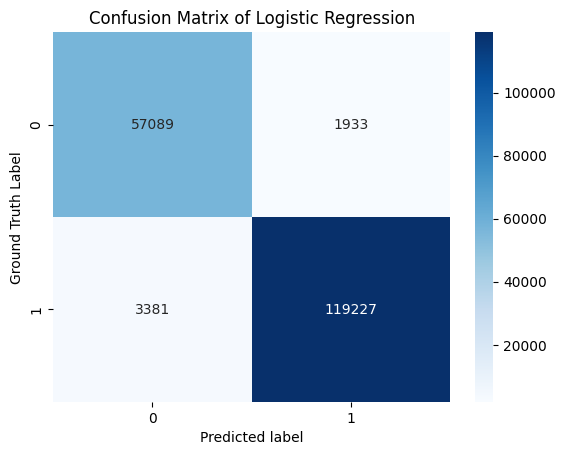

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)

# Create heatmap visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted label')
plt.ylabel('Ground Truth Label')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()

ROC curve (precision-recall curve)

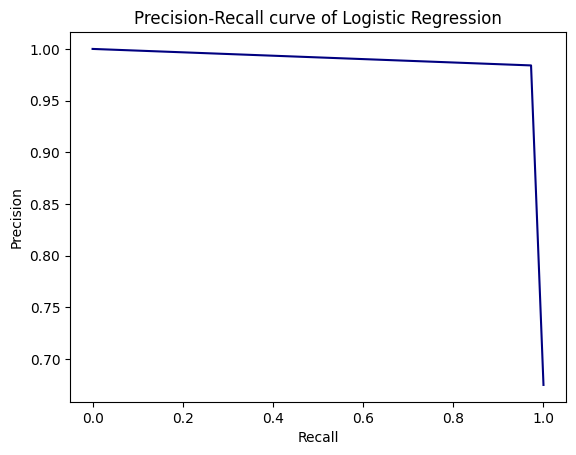

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Create a ROC curve
precision, recall, th = precision_recall_curve(y_test, y_pred_lr)


# Create plot
plt.plot(recall, precision, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall curve of Logistic Regression")

# Show plot
plt.show()

Negative words WordCloud on Sentiment Analysis

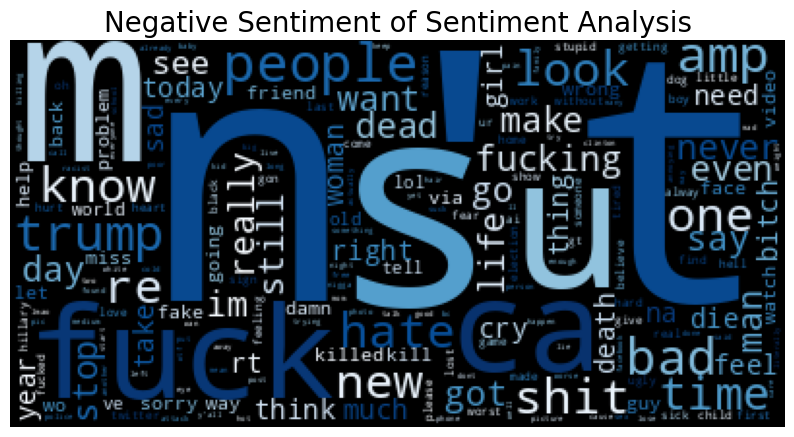

In [22]:
# wordcloud on Sentiment Analysis(negative words)

# Import the wordcloud library
from wordcloud import WordCloud

allwords_neg = ' '.join([i for i in data['text'][data['label'] == 0]])
wordcloud = WordCloud(collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap='Blues_r')
# Generate a word cloud
wordcloud.generate(allwords_neg)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud)
plt.title("Negative Sentiment of Sentiment Analysis", fontsize= 20)
plt.axis('off')
plt.show() 

Positive words WordCloud on Sentiment Analysis

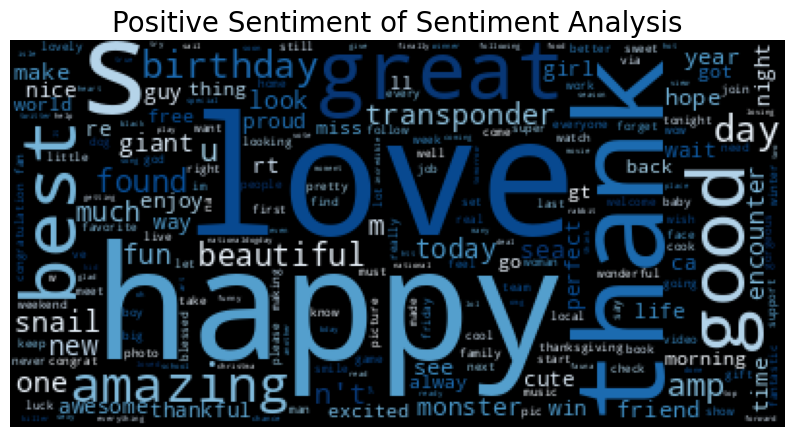

In [23]:
# wordcloud on Sentiment Analysis(positive words)

# Import the wordcloud library
from wordcloud import WordCloud

allwords_pos = ' '.join([i for i in data['text'][data['label'] == 1]])
wordcloud = WordCloud(collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap='Blues_r')
# Generate a word cloud
wordcloud.generate(allwords_pos)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud)
plt.title("Positive Sentiment of Sentiment Analysis", fontsize= 20)
plt.axis('off')
plt.show() 

## Part 2 Sentiment Classification

In [24]:
#install vaderSentimentlibrary
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 3.7 MB/s eta 0:00:00


In [25]:
#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

### 2.1 Using Web-Scrapping Data from Twitter 
dataset: 3.15.2023-3.18.2023 English tweets about Russia's War in Ukraine <br>
BwandoWando. (2023). <i>🇺🇦 Ukraine Conflict Twitter Dataset</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/5243632

2.1.1 Data Pre-Process

In [ ]:
#df1 = pd.read_csv('20230315_UkraineCombinedTweetsDeduped.csv')
#df2 = pd.read_csv('20230316_UkraineCombinedTweetsDeduped.csv')
#df3 = pd.read_csv('20230317_UkraineCombinedTweetsDeduped.csv')
#df4 = pd.read_csv('20230318_UkraineCombinedTweetsDeduped.csv')

#df_twitter_p2 = pd.concat([df1, df2, df3, df4])
#df_twitter_p2.head()

In [ ]:
#df_twitter_p2.info()

In [ ]:
# read english tweets 
#df_twitter_p2 = df_twitter_p2[['language', 'text', 'hashtags']]
#df_twitter_p2 = df_twitter_p2[df_twitter_p2['language'].isin(['en'])].reset_index()

In [ ]:
#df_twitter_p2["text"] = df_twitter_p2["text"].apply(clean_text)

In [ ]:
#Save the cleaned tweets as csv
#df_twitter_p2.to_csv('/content/cleaned_tweet_p2.csv', index = None, header=True)

To save time, you can skip the previous steps and start from here by reading the cleaned data

In [54]:
cleaned_tweet_p2 = pd.read_csv('/cleaned_tweet_p2.csv') #can use cleaned data directly to save time and comment out the followed line
#cleaned_tweet_p2 = df_twitter_p2.copy()
cleaned_tweet_p2.isnull().sum()

index        0
language     0
text        29
hashtags     0
dtype: int64

When save the cleaned data to .csv, got some missing values (29/412,197), it won't occur if read the raw data and clean it directly. We just drop the missing values if we read the cleaned data.

In [55]:
#Drop missing values
cleaned_tweet_p2.dropna(inplace=True)

### 2.1.2 Apply our best-preformed trained sentiment model from Part 1

In [56]:
X_tweet_p2_all = vectorizer.transform(cleaned_tweet_p2['text'])

In [57]:
# apply the sentiment for the all tweet data
y_pred_tweet_p2_all = best_lr.predict(X_tweet_p2_all)
cleaned_tweet_p2['p1 best model label'] = y_pred_tweet_p2_all

In [58]:
df_plot = cleaned_tweet_p2['p1 best model label'].value_counts(ascending = True).to_frame()
df_plot.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

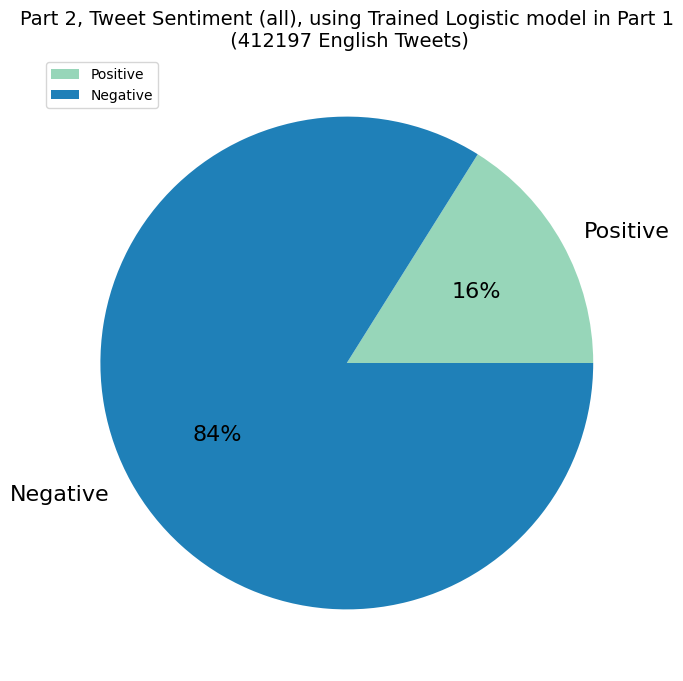

In [59]:
color = sns.color_palette("YlGnBu", 2)

df_plot.plot(kind='pie', subplots=True, autopct='%.0f%%', figsize=(20, 8), fontsize=16, colors = color)
plt.title('Part 2, Tweet Sentiment (all), using Trained Logistic model in Part 1\n (%s English Tweets)'%len(cleaned_tweet_p2['p1 best model label']), fontsize = 14)
plt.ylabel('')
plt.legend(loc = 'upper left')

### 2.1.3 Apply pre-trained sentiment classification model VADER (Valence Aware Dictionary and Sentiment Reasoner) 

We choose VADER as it is a lexicon and rule-based sentiment analysis tool that is specifically designed to detect sentiments expressed in social media like twitter. <br>

We use VADER to filter out tweets with neutral sentiment

In [60]:
def vader_sentiment(df):
  # Create a SentimentIntensityAnalyzer object.
  sid_obj = SentimentIntensityAnalyzer()
  def sentiment_vader(text):
    sentiment_dict = sid_obj.polarity_scores(text)

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return overall_sentiment
  df['VADER Sentiment'] = df['text'].apply(lambda x :sentiment_vader(x))

In [61]:
def vader_label(df):
  # Create a SentimentIntensityAnalyzer object.
  sid_obj = SentimentIntensityAnalyzer()
  def sentiment_vader(text):
    sentiment_dict = sid_obj.polarity_scores(text)

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment_label = "1"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment_label = "0"

    else :
        overall_sentiment_label = "0.5"
  
    return overall_sentiment_label
  df['VADER Label'] = df['text'].apply(lambda x :sentiment_vader(x))

In [62]:
vader_sentiment(cleaned_tweet_p2)
vader_label(cleaned_tweet_p2)

In [63]:
cleaned_tweet_p2

index language                                               text  \
0            1       en  online class homework , assignment exam help e...   
1            2       en  british intelligence ukrainerussiawar map mar ...   
2            4       en  learn love prosper video ! russianwarcrimes uk...   
3            5       en  usa -the pentagon plan increase spending cyber...   
4            6       en  tomorrow 03.15.2023 buildinginsurance glassins...   
...        ...      ...                                                ...   
412221  184247       en  ukrainian soldier bakhmut , house house fighti...   
412222  184248       en  poland slovakia jointly transfer 33 mig-29 fig...   
412223  184250       en  russia syria assad ukraine zelenskywarcriminal...   
412224  184251       en  moscow , flag european country removed europe ...   
412225  184252       en  nail coffin russian troopsukraine war video fo...   

                                                 hashtags  \
0       [{'text': 'USA', 'indices': [141, 145]}, {'tex...   
1       [{'text': 'UkraineRussiaWar', 'indices': [21, ...   
2       [{'text': 'RussianWarCrimes', 'indices': [69, ...   
3       [{'text': 'USA', 'indices': [0, 4]}, {'text': ...   
4       [{'text': 'buildinginsurance', 'indices': [21,...   
...                                                   ...   
412221  [{'text': 'Bakhmut', 'indices': [23, 31]}, {'t...   
412222  [{'text': 'Poland', 'indices': [84, 91]}, {'te...   
412223  [{'text': 'Russia', 'indices': [0, 7]}, {'text...   
412224           [{'text': 'Moscow', 'indices': [3, 10]}]   
412225  [{'text': 'Canada', 'indices': [68, 75]}, {'te...   

        p1 best model label VADER Sentiment VADER Label  
0                         0        Positive           1  
1                         0        Positive           1  
2                         1        Positive           1  
3                         0        Positive           1  
4                         1         Neutral         0.5  
...                     ...             ...         ...  
412221                    0        Negative           0  
412222                    1        Positive           1  
412223                    0        Negative           0  
412224                    0         Neutral         0.5  
412225                    0        Negative           0  

[412197 rows x 7 columns]

In [64]:
df_plot1 = cleaned_tweet_p2['VADER Sentiment'].value_counts(ascending = True).to_frame()

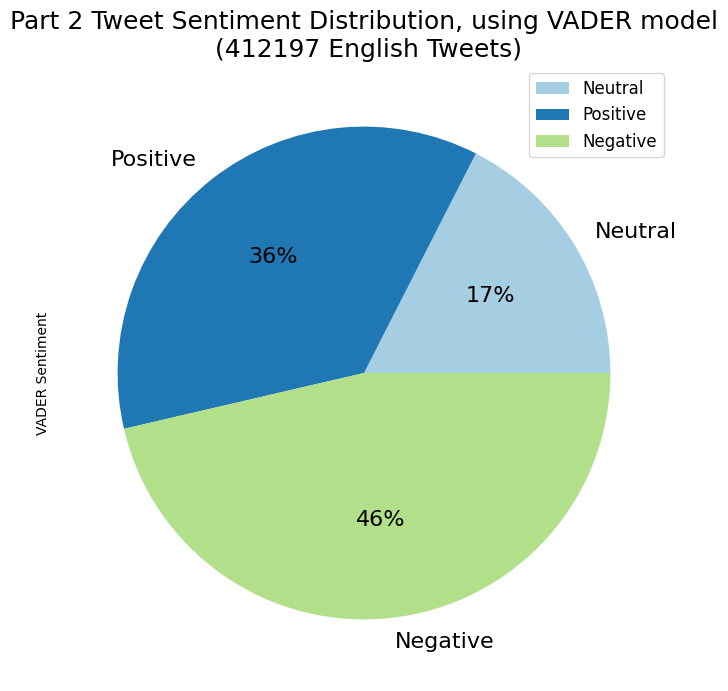

In [65]:
color = sns.color_palette("Paired", 9)
df_plot1.plot(kind='pie', subplots=True, figsize=(20, 8), fontsize=16, autopct='%.0f%%', colors = color)
plt.title('Part 2 Tweet Sentiment Distribution, using VADER model\n (%s English Tweets)'%len(cleaned_tweet_p2['VADER Sentiment']), fontsize = 18)
plt.legend(loc = 'best',fontsize = 12)

In [66]:
# drop neutral tweets
cleaned_tweet_useful = cleaned_tweet_p2[cleaned_tweet_p2['VADER Label'].isin(['0.5'])==False]

In [67]:
cleaned_tweet_useful

index language                                               text  \
0            1       en  online class homework , assignment exam help e...   
1            2       en  british intelligence ukrainerussiawar map mar ...   
2            4       en  learn love prosper video ! russianwarcrimes uk...   
3            5       en  usa -the pentagon plan increase spending cyber...   
5            7       en  russia ’ combat loss ukrainewar front includin...   
...        ...      ...                                                ...   
412220  184245       en  ukrainian child destined experience horror war...   
412221  184247       en  ukrainian soldier bakhmut , house house fighti...   
412222  184248       en  poland slovakia jointly transfer 33 mig-29 fig...   
412223  184250       en  russia syria assad ukraine zelenskywarcriminal...   
412225  184252       en  nail coffin russian troopsukraine war video fo...   

                                                 hashtags  \
0       [{'text': 'USA', 'indices': [141, 145]}, {'tex...   
1       [{'text': 'UkraineRussiaWar', 'indices': [21, ...   
2       [{'text': 'RussianWarCrimes', 'indices': [69, ...   
3       [{'text': 'USA', 'indices': [0, 4]}, {'text': ...   
5       [{'text': 'UkraineWar', 'indices': [26, 37]}, ...   
...                                                   ...   
412220  [{'text': 'Russia', 'indices': [107, 114]}, {'...   
412221  [{'text': 'Bakhmut', 'indices': [23, 31]}, {'t...   
412222  [{'text': 'Poland', 'indices': [84, 91]}, {'te...   
412223  [{'text': 'Russia', 'indices': [0, 7]}, {'text...   
412225  [{'text': 'Canada', 'indices': [68, 75]}, {'te...   

        p1 best model label VADER Sentiment VADER Label  
0                         0        Positive           1  
1                         0        Positive           1  
2                         1        Positive           1  
3                         0        Positive           1  
5                         0        Negative           0  
...                     ...             ...         ...  
412220                    0        Negative           0  
412221                    0        Negative           0  
412222                    1        Positive           1  
412223                    0        Negative           0  
412225                    0        Negative           0  

[340072 rows x 7 columns]

### 2.1.4 Compare the results of our trained model with VADER

As Vader model classify the sentiment into three classes, but our model only classify sentiment into two models, we decided to exclude the rows that's been classified as 'Neutral' by Vader so that we can now compare these two models with only two classes.

In [68]:
X_tweet_p2 = vectorizer.transform(cleaned_tweet_useful['text'])

In [69]:
# apply the sentiment for the non-neutral tweet data
y_pred_tweet_p2 = best_lr.predict(X_tweet_p2)
cleaned_tweet_useful['p1 best model label (vader non-neutral only)'] = y_pred_tweet_p2

Check if extracting neutral tweet will affect seniment labeling using part 1 model.

In [70]:
(cleaned_tweet_useful['p1 best model label'] != cleaned_tweet_useful['p1 best model label (vader non-neutral only)']).sum()

0

In [71]:
df_plot2 = cleaned_tweet_useful['VADER Label'].value_counts(ascending = True).to_frame()
df_plot3 = cleaned_tweet_useful['p1 best model label (vader non-neutral only)'].value_counts(ascending = True).to_frame()
df_plot2.rename(index ={'0': 'Negative', '1': 'Positive'}, inplace = True)
df_plot3.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

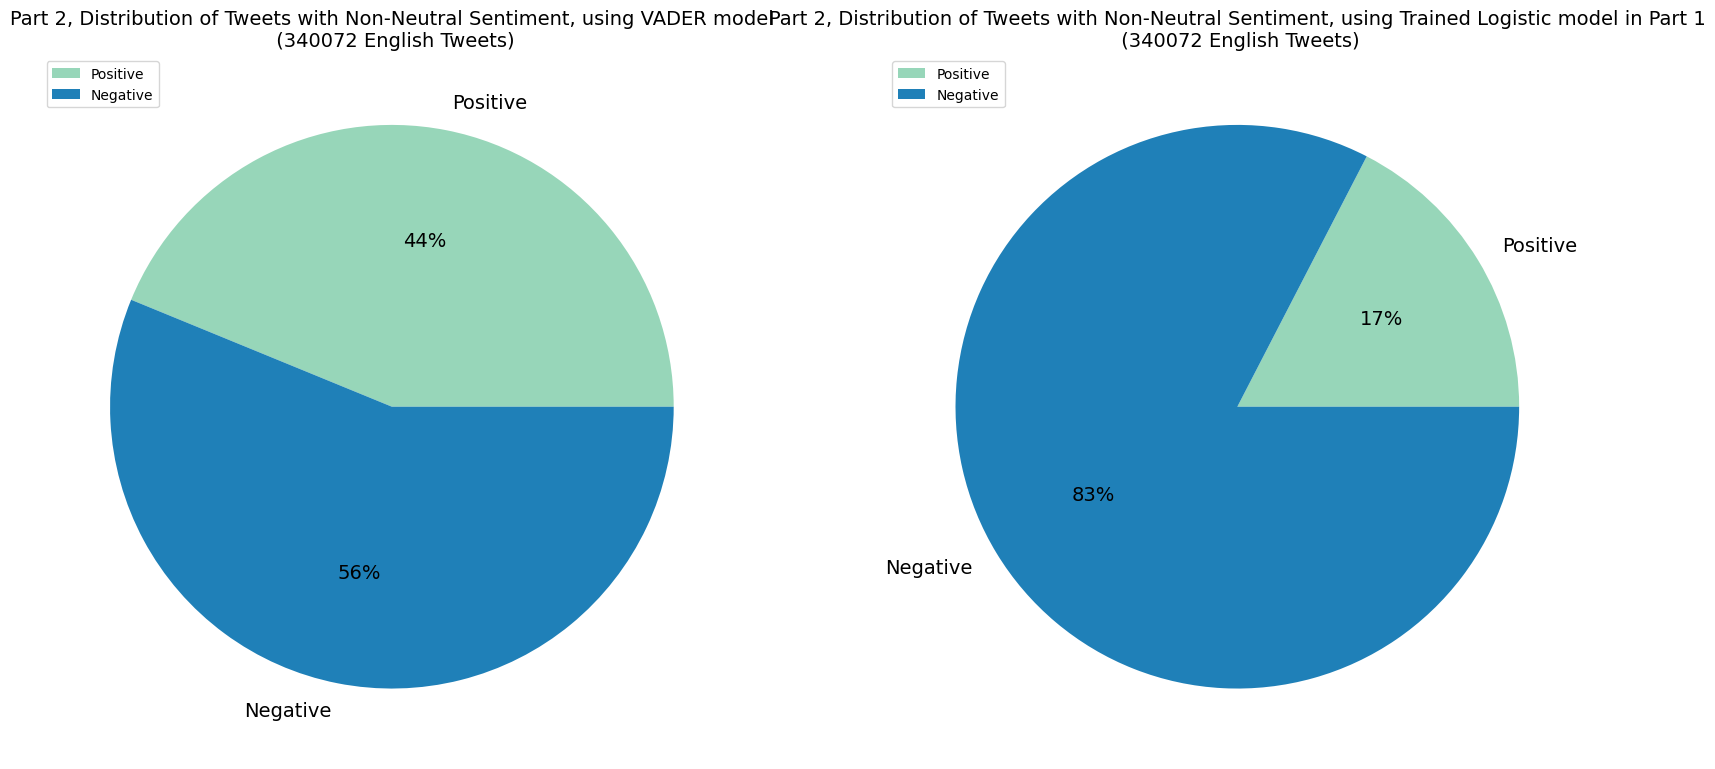

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot2.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Tweets with Non-Neutral Sentiment, using VADER model\n (%s English Tweets)'%len(cleaned_tweet_useful['VADER Sentiment']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot3.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Tweets with Non-Neutral Sentiment, using Trained Logistic model in Part 1\n (%s English Tweets)'%len(cleaned_tweet_useful['p1 best model label (vader non-neutral only)']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

More Sentiment Analysis to go

In [73]:
lemmatizer = WordNetLemmatizer()
cleaned_tweet_p2['binary ukraine'] = cleaned_tweet_p2['text'].apply(lambda x: 'ukraine' in [lemmatizer.lemmatize(word) for word in word_tokenize(x)]).map({False: 0, True: 1})
cleaned_tweet_p2['binary russia'] = cleaned_tweet_p2['text'].apply(lambda x: 'russia' in [lemmatizer.lemmatize(word) for word in word_tokenize(x)]).map({False: 0, True: 1})

In [74]:
def check_russia_only(t):
  tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(t)]
  return 'russia' in tokens and 'ukraine' not in tokens

def check_ukraine_only(t):
  tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(t)]
  return 'russia' not in tokens and 'ukraine' in tokens

In [75]:
cleaned_tweet_p2['binary russia only'] = cleaned_tweet_p2['text'].apply(lambda x: check_russia_only(x)).map({False: 0, True: 1})
cleaned_tweet_p2['binary ukraine only'] = cleaned_tweet_p2['text'].apply(lambda x: check_ukraine_only(x)).map({False: 0, True: 1})

In [76]:
cleaned_tweet_useful = cleaned_tweet_p2[cleaned_tweet_p2['VADER Label'].isin(['0.5'])==False]

In [169]:
df_ukraine = cleaned_tweet_useful[cleaned_tweet_useful['binary ukraine'] == 1]
df_russia = cleaned_tweet_useful[cleaned_tweet_useful['binary russia'] == 1]
df_russia_only = cleaned_tweet_useful[cleaned_tweet_useful['binary russia only'] == 1]
df_ukraine_only = cleaned_tweet_useful[cleaned_tweet_useful['binary ukraine only'] == 1]

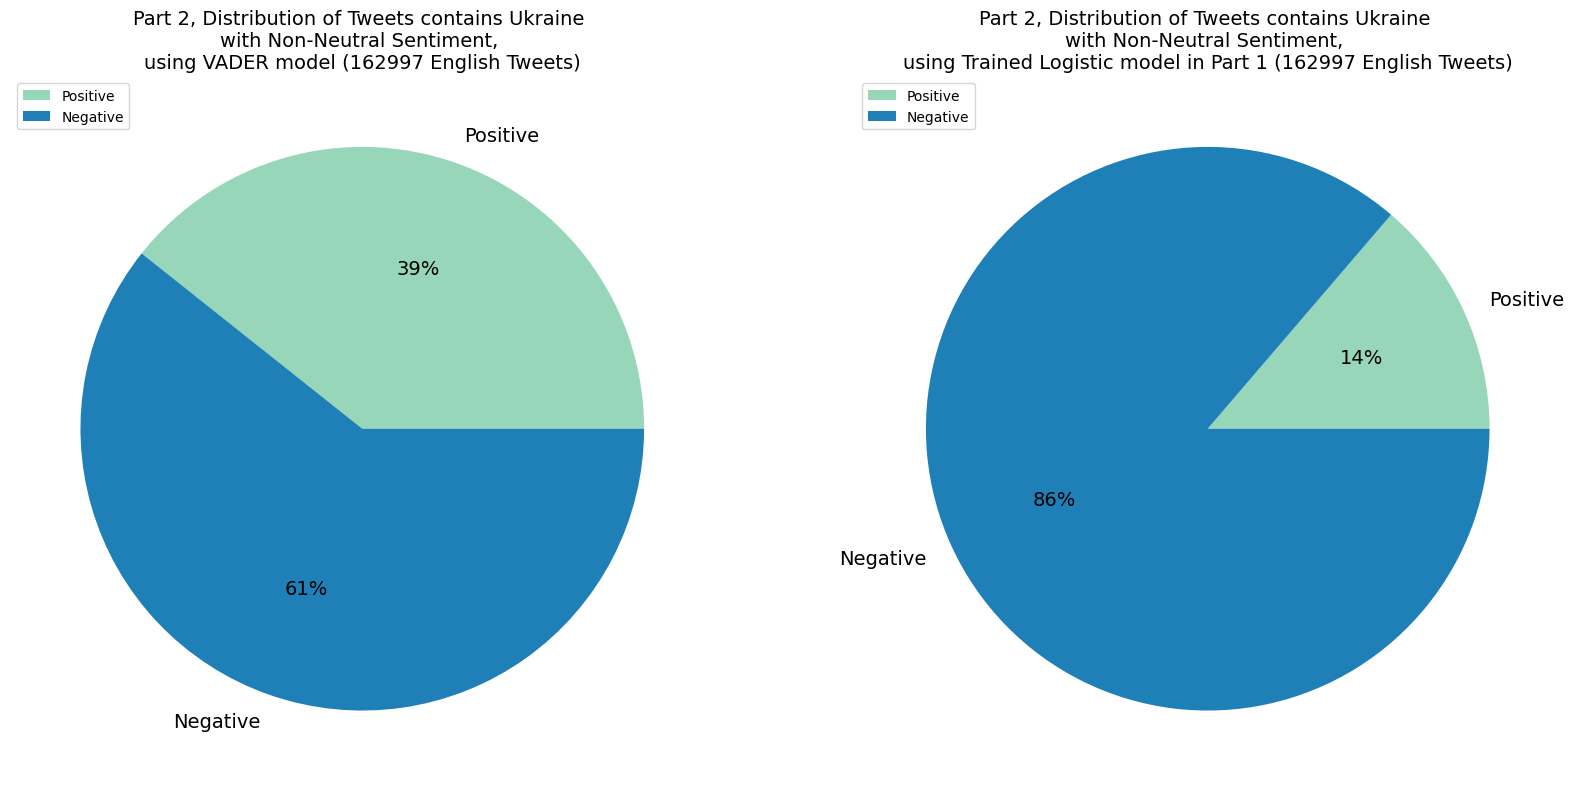

In [170]:
df_plot4 = df_ukraine['VADER Label'].value_counts(ascending = True).to_frame()
df_plot5 = df_ukraine['p1 best model label'].value_counts(ascending = True).to_frame()
df_plot4.rename(index ={'0': 'Negative', '1': 'Positive'}, inplace = True)
df_plot5.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot4.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Tweets contains Ukraine \nwith Non-Neutral Sentiment, \nusing VADER model (%s English Tweets)'%len(df_ukraine['VADER Sentiment']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot5.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Tweets contains Ukraine \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Tweets)'%len(df_ukraine['p1 best model label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

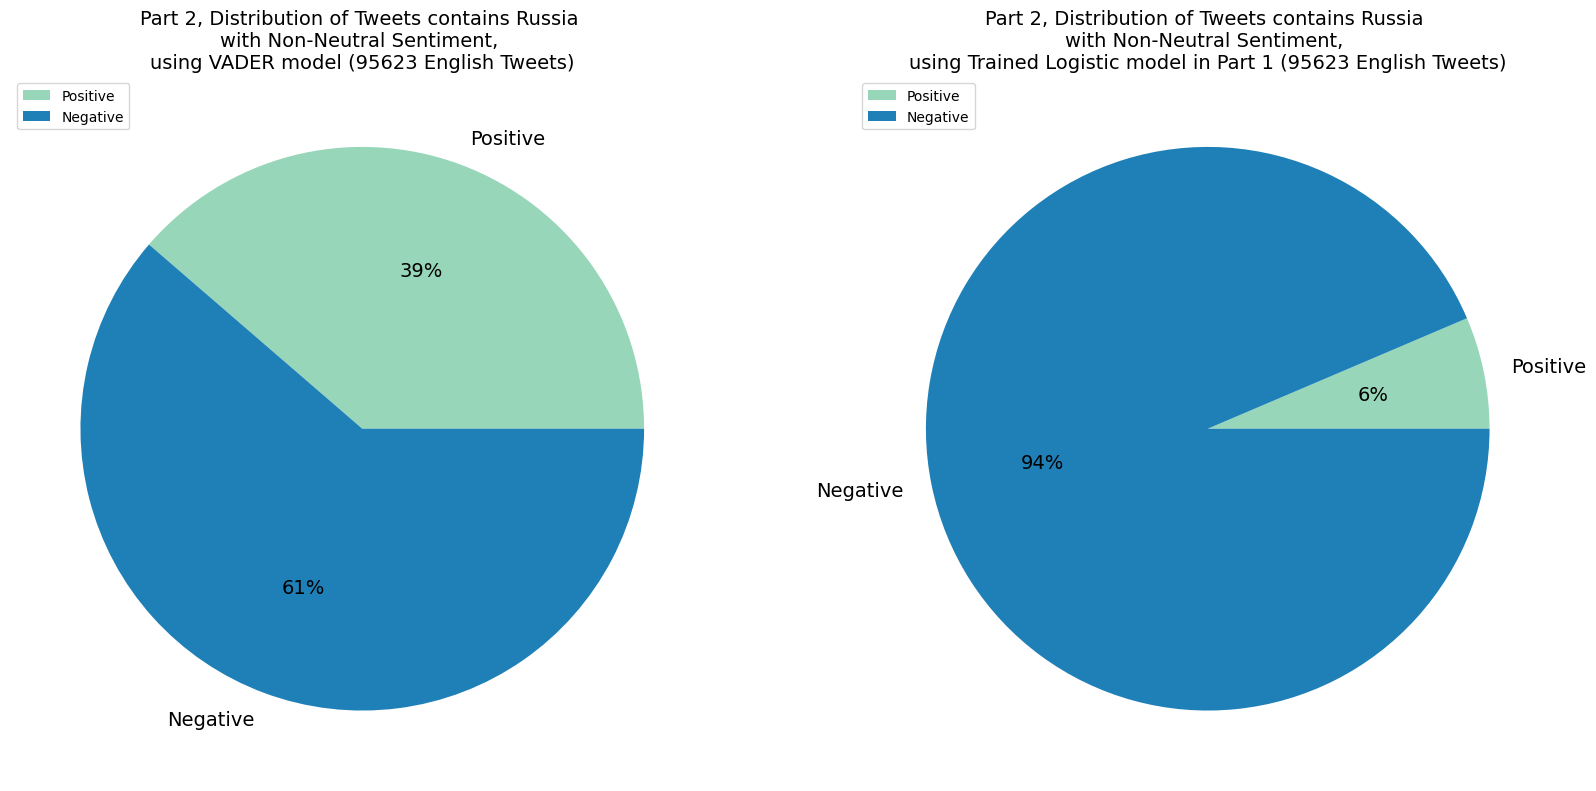

In [171]:
df_plot6 = df_russia['VADER Label'].value_counts(ascending = True).to_frame()
df_plot7 = df_russia['p1 best model label'].value_counts(ascending = True).to_frame()
df_plot6.rename(index ={'0': 'Negative', '1': 'Positive'}, inplace = True)
df_plot7.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot6.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Tweets contains Russia \nwith Non-Neutral Sentiment, \nusing VADER model (%s English Tweets)'%len(df_russia['VADER Sentiment']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot7.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Tweets contains Russia \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Tweets)'%len(df_russia['p1 best model label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

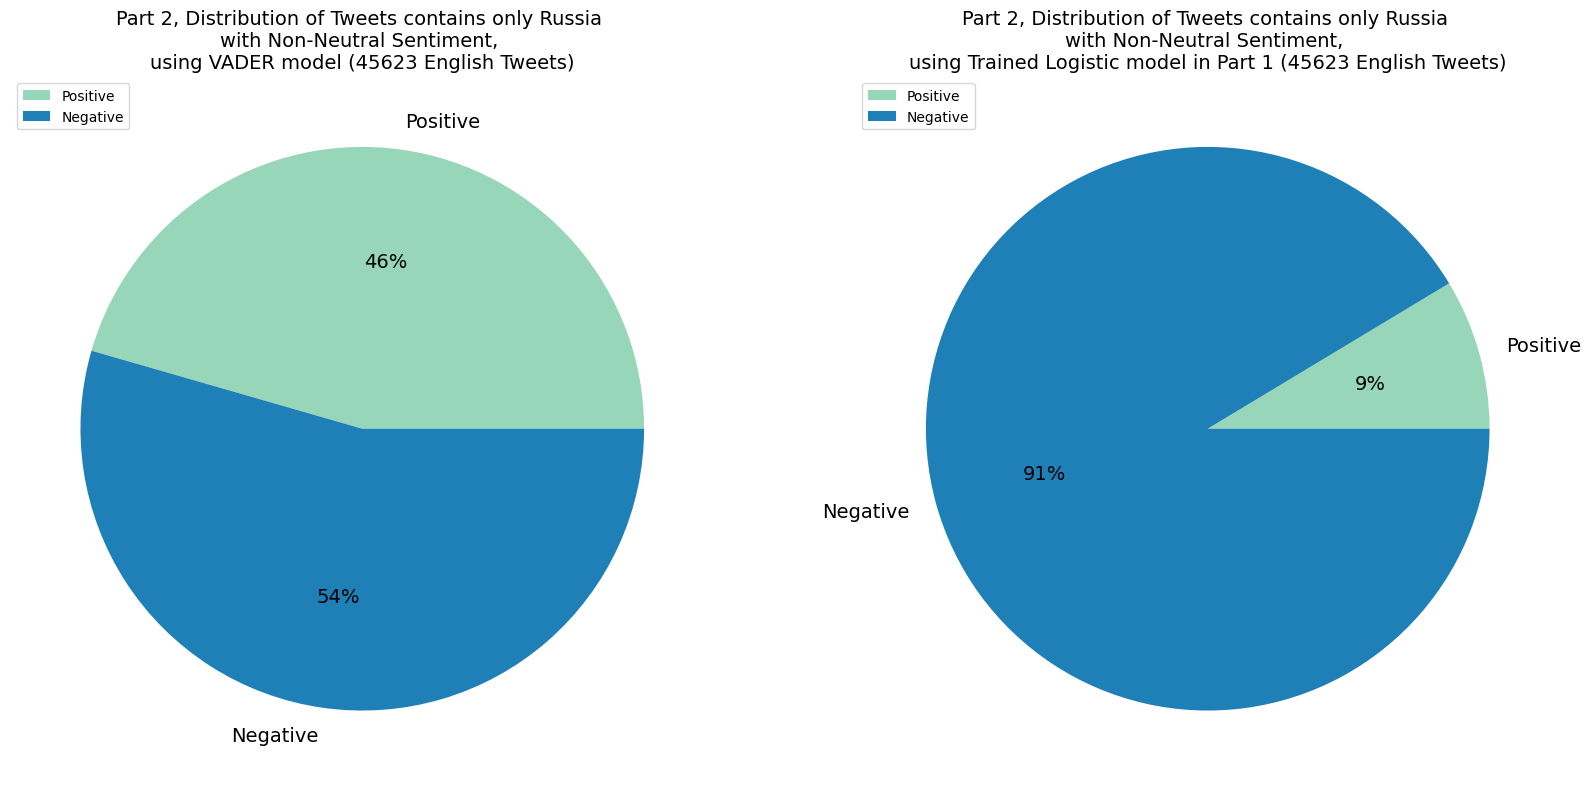

In [172]:
df_plot8 = df_russia_only ['VADER Label'].value_counts(ascending = True).to_frame()
df_plot9 = df_russia_only ['p1 best model label'].value_counts(ascending = True).to_frame()
df_plot8.rename(index ={'0': 'Negative', '1': 'Positive'}, inplace = True)
df_plot9.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot8.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Tweets contains only Russia \nwith Non-Neutral Sentiment, \nusing VADER model (%s English Tweets)'%len(df_russia_only['VADER Sentiment']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot9.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Tweets contains only Russia \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Tweets)'%len(df_russia_only['p1 best model label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

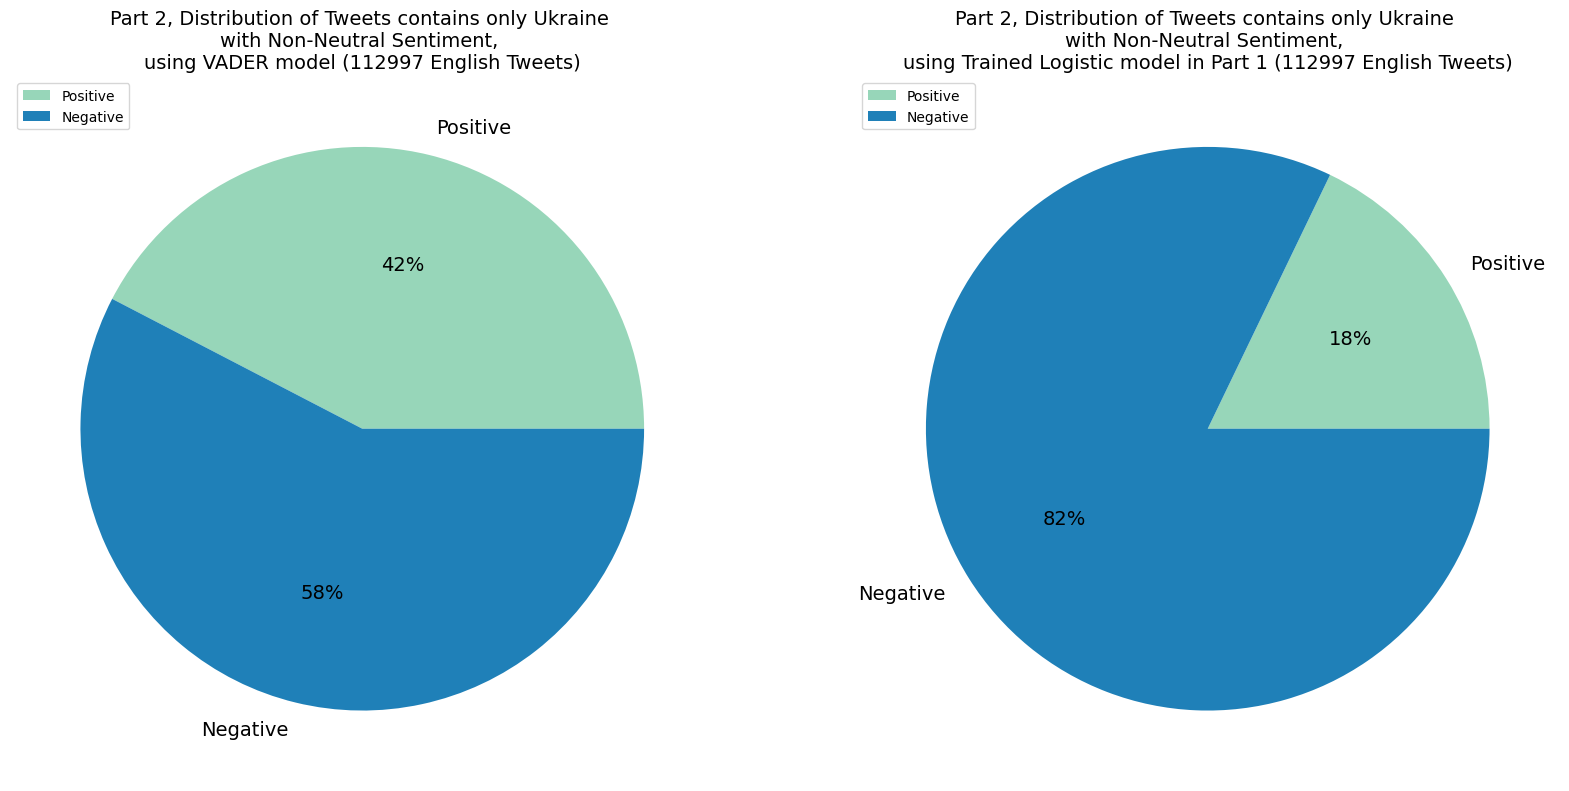

In [173]:
df_plot10 = df_ukraine_only ['VADER Label'].value_counts(ascending = True).to_frame()
df_plot11 = df_ukraine_only ['p1 best model label'].value_counts(ascending = True).to_frame()
df_plot10.rename(index ={'0': 'Negative', '1': 'Positive'}, inplace = True)
df_plot11.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot10.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Tweets contains only Ukraine \nwith Non-Neutral Sentiment, \nusing VADER model (%s English Tweets)'%len(df_ukraine_only['VADER Sentiment']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot11.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Tweets contains only Ukraine \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Tweets)'%len(df_ukraine_only['p1 best model label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

In [82]:
cleaned_tweet_useful.to_csv('non-neutral tweets labeled using vader and lg.csv')
cleaned_tweet_p2.to_csv('all tweets labeled using vader and lg.csv')

### 2.2 Using Ukraine Russia War Reddit Data
Download the dataset from https://www.kaggle.com/datasets/diyacharya/ukraine-russia-war-reddit-data

#### 2.2.1 Data Pre-Process

In [88]:
reddit_raw = pd.read_csv('/russian_invasion_of_ukraine.csv')
reddit_raw.head()

title score      id  \
0  Live updates: Russians destroy Chernobyl labor...    56  tkjwjl   
1  Romania Is Handing Out 30 Million Anti-Radiati...   265  tkjqga   
2    Oil rises towards $116 as EU weighs Russian ban    28  tk1utj   
3  Russia Sends $66 Million Coupon to Depository ...    44  tk1nlm   
4  Ukraine war latest: Global diesel shortage loo...    31  tk1ky3   

                                                 url  comms_num       created  \
0  https://www.washingtonpost.com/politics/live-u...       15.0  1.648003e+09   
1  https://www.vice.com/amp/en/article/pkpw7b/iod...       22.0  1.648002e+09   
2  https://www.reuters.com/business/energy/oil-op...        2.0  1.647952e+09   
3  https://www.bloomberg.com/news/articles/2022-0...        8.0  1.647951e+09   
4  https://www.ft.com/content/795b432f-b189-4c91-...        3.0  1.647951e+09   

  body            timestamp  
0  NaN  2022-03-23 02:34:15  
1  NaN  2022-03-23 02:25:07  
2  NaN  2022-03-22 12:27:29  
3  NaN  2022-03-22 12:17:29  
4  NaN  2022-03-22 12:13:26

In [89]:
 reddit_raw = reddit_raw[reddit_raw['title'] == 'Comment']
 reddit_raw.dropna(subset=['body'], inplace=True)
 reddit_raw.rename(columns={'body': 'comments'}, inplace=True)
 reddit_raw.head()

title score       id  url  comms_num       created  \
9   Comment     1  i1rqi48  NaN        0.0  1.648023e+09   
10  Comment     2  i1rqhy7  NaN        0.0  1.648023e+09   
11  Comment     7  i1rqhk0  NaN        0.0  1.648023e+09   
12  Comment     1  i1rqhjy  NaN        0.0  1.648023e+09   
13  Comment     3  i1rqhh1  NaN        0.0  1.648023e+09   

                                             comments            timestamp  
9   What if I told you, barbarians already, this e...  2022-03-23 08:07:18  
10  Oh no. Decathlon is bad? I just ordered from t...  2022-03-23 08:07:14  
11  Last I read they have commited almost all thei...  2022-03-23 08:07:04  
12  Lukashenko was already president…. The protest...  2022-03-23 08:07:04  
13                                          Russia: 🥺  2022-03-23 08:07:02

In [90]:
 reddit_df = reddit_raw["comments"].apply(clean_text)
#reddit_df.to_csv('/content/cleaned_reddit_p2.csv', index = None, header=True)
# Focus on the comments column only
 reddit_df = reddit_df.to_frame()

#### 2.2.2 Apply our best-preformed trained sentiment model from Part 1

In [91]:
X_reddit = vectorizer.transform(reddit_df['comments'])

In [92]:
# apply the sentiment for reddit data
y_pred_reddit = best_lr.predict(X_reddit)

In [93]:
reddit_df['lr_predicted_label'] = y_pred_reddit

In [94]:
reddit_df.head()

comments  lr_predicted_label
9   told , barbarian already , event notwithstandi...                   0
10                 oh . decathlon bad ? ordered them…                   0
11  last read commited almost combat ground force ...                   0
12  lukashenko already president… . protest people...                   0
13                                           russia :                   0

In [95]:
reddit_df.to_csv('/content/labeled_reddit_p2.csv', index = None, header=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [96]:
reddit_labels_plot = reddit_df['lr_predicted_label'].value_counts(ascending = True).to_frame()

reddit_labels_plot.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

<Axes: title={'center': 'Part 2, Reddit comments Sentiment (all), using Trained Logistic model in Part 1\n (200233 raddit comments)'}>

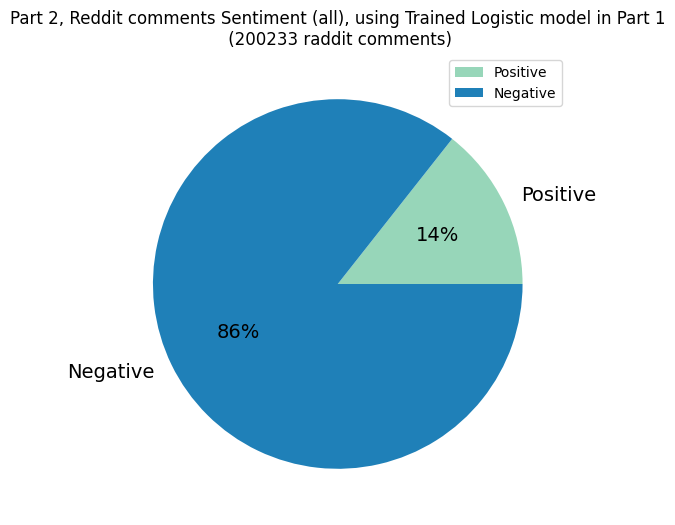

In [97]:
color = sns.color_palette("YlGnBu", 2)

reddit_labels_plot.plot(kind='pie', y = 'lr_predicted_label', autopct='%.0f%%', fontsize = 14, colors = color, figsize=(11, 6),
              title = 'Part 2, Reddit comments Sentiment (all), using Trained Logistic model in Part 1\n (%s raddit comments)'% len(reddit_df['lr_predicted_label']), 
              ylabel='', )

#### 2.2.3 Apply pre-trained sentiment classification model VADER (Valence Aware Dictionary and Sentiment Reasoner) 

In [98]:
sid = SentimentIntensityAnalyzer()
reddit_df['compound'] = reddit_df['comments'].apply(sid.polarity_scores).apply(lambda x : x['compound'])

In [99]:
reddit_df.head()

comments  lr_predicted_label  \
9   told , barbarian already , event notwithstandi...                   0   
10                 oh . decathlon bad ? ordered them…                   0   
11  last read commited almost combat ground force ...                   0   
12  lukashenko already president… . protest people...                   0   
13                                           russia :                   0   

    compound  
9     0.0000  
10   -0.5423  
11   -0.2748  
12    0.8658  
13    0.0000

In [100]:
THRESHOLD = 0.05

conditions = [
    (reddit_df['compound'] <= -THRESHOLD),
    (reddit_df['compound'] > -THRESHOLD) & (reddit_df['compound'] < THRESHOLD),
    (reddit_df['compound'] >= THRESHOLD)
]

values = ["neg", "neu", "pos"]
reddit_df['vadar_label'] = np.select(conditions, values)

In [101]:
reddit_df.head()

comments  lr_predicted_label  \
9   told , barbarian already , event notwithstandi...                   0   
10                 oh . decathlon bad ? ordered them…                   0   
11  last read commited almost combat ground force ...                   0   
12  lukashenko already president… . protest people...                   0   
13                                           russia :                   0   

    compound vadar_label  
9     0.0000         neu  
10   -0.5423         neg  
11   -0.2748         neg  
12    0.8658         pos  
13    0.0000         neu

In [102]:
reddit_labels_plot_vadar = reddit_df['vadar_label'].value_counts(ascending = True).to_frame()

reddit_labels_plot_vadar.rename(index ={'neg': 'Negative', 'pos': 'Positive', 'neu':'Neutral'}, inplace = True)

<Axes: title={'center': 'Part 2, Reddit comments Sentiment (all), using Vader\n (200233 reddit comments)'}>

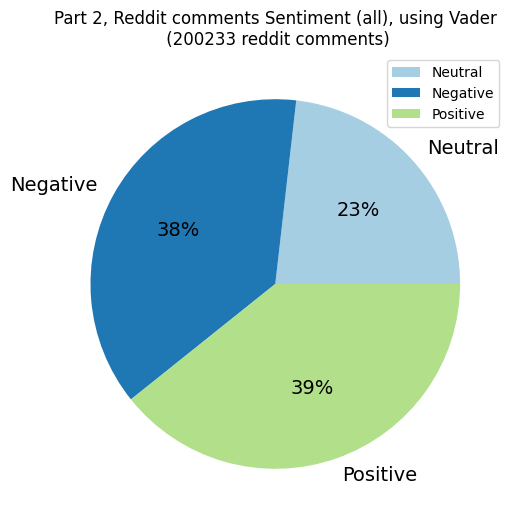

In [103]:
color = sns.color_palette("Paired", 9)

reddit_labels_plot_vadar.plot(kind='pie', y = 'vadar_label', autopct='%.0f%%', fontsize = 14, colors = color, figsize=(11, 6),
              title = 'Part 2, Reddit comments Sentiment (all), using Vader\n (%s reddit comments)'% int(reddit_labels_plot_vadar.sum()), 
              ylabel='')

#### 2.2.4 Compare the results of our trained model with VADER  
As Vader model classify the sentiment into three classes, but our model only classify sentiment into two models, we decided to exclude the rows that's been classified as 'Neutral' by Vader so that we can now compare these two models with only two classes.

In [104]:
reddit_df_non_neu = reddit_df[reddit_df['vadar_label'] != 'neu']
reddit_df_non_neu = reddit_df_non_neu[['comments', 'vadar_label']]
reddit_df_non_neu.head()

comments vadar_label
10                 oh . decathlon bad ? ordered them…         neg
11  last read commited almost combat ground force ...         neg
12  lukashenko already president… . protest people...         pos
14  please divide em europe . use nuclear deterren...         pos
15  realistically russian would fight bit enthusia...         pos

In [105]:
reddit_df_non_neu['vadar'] = reddit_df_non_neu['vadar_label']
reddit_df_non_neu['vadar'] = reddit_df_non_neu['vadar'].map({'pos': 1, 'neg': 0})

In [106]:
X_reddit_non_neu = vectorizer.transform(reddit_df_non_neu['comments'])

In [107]:
# apply the sentiment for reddit data
y_pred_reddit_non_neu = best_lr.predict(X_reddit_non_neu)

In [108]:
reddit_df_non_neu['lr_predicted_label'] = y_pred_reddit_non_neu

In [109]:
reddit_df_non_neu_plot = reddit_df_non_neu['lr_predicted_label'].value_counts(ascending = True).to_frame()
reddit_df_non_neu_plot_vader = reddit_df_non_neu['vadar_label'].value_counts(ascending = True).to_frame()

reddit_df_non_neu_plot.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)
reddit_df_non_neu_plot_vader.rename(index ={'neg': 'Negative', 'pos': 'Positive'}, inplace = True)

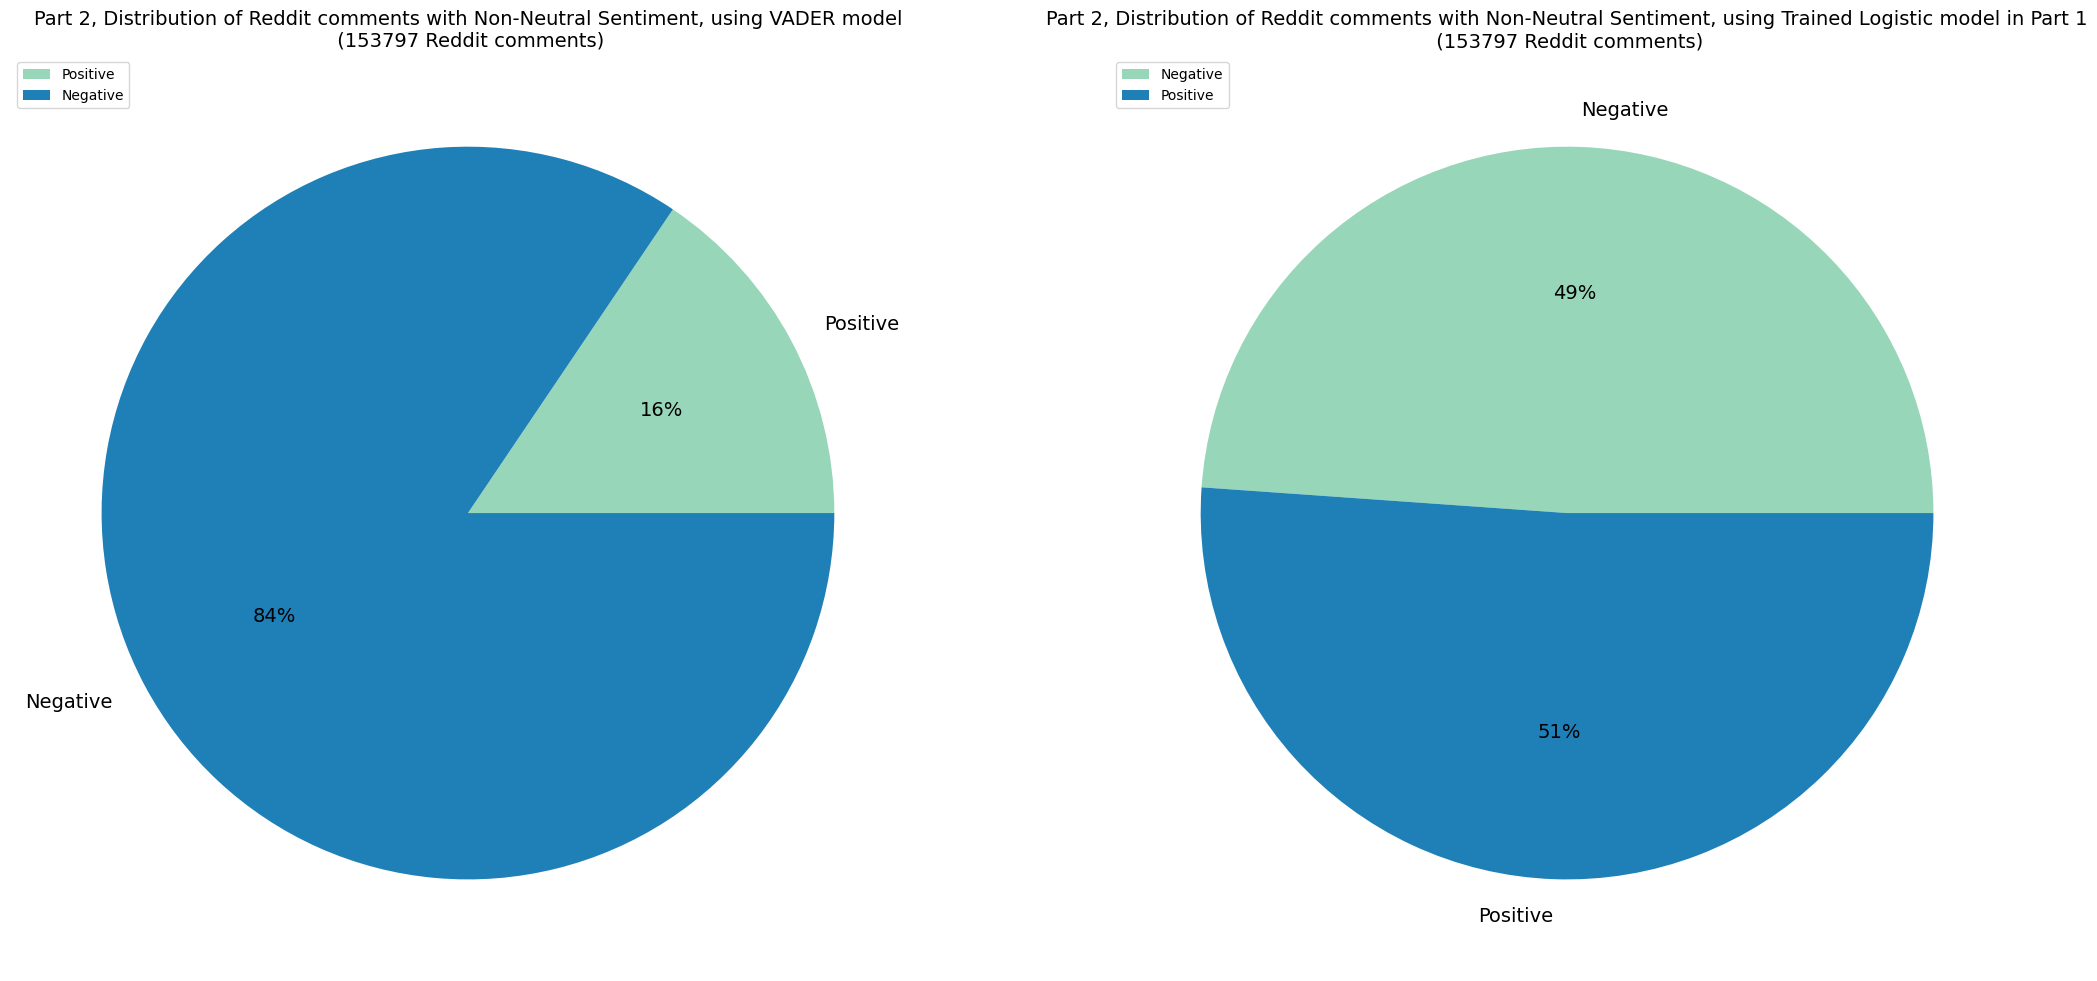

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(26, 18))
color = sns.color_palette("YlGnBu", 2)

reddit_df_non_neu_plot.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Reddit comments with Non-Neutral Sentiment, using VADER model\n (%s Reddit comments)'%len(reddit_df_non_neu['lr_predicted_label']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

reddit_df_non_neu_plot_vader.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Reddit comments with Non-Neutral Sentiment, using Trained Logistic model in Part 1\n (%s Reddit comments)'%len(reddit_df_non_neu['vadar_label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')


plt.show()

More Sentiment Analysis to go

In [111]:
lemmatizer = WordNetLemmatizer()

reddit_df_non_neu['ukraine_mentioned'] = reddit_df_non_neu['comments']
reddit_df_non_neu['ukraine_mentioned'] = reddit_df_non_neu['ukraine_mentioned'].map(lambda x: 'ukraine' in [lemmatizer.lemmatize(word) for word in word_tokenize(x)]).map({False: 0, True: 1})

reddit_df_non_neu['russia_mentioned'] = reddit_df_non_neu['comments']
reddit_df_non_neu['russia_mentioned'] = reddit_df_non_neu['russia_mentioned'].map(lambda x: 'russia' in [lemmatizer.lemmatize(word) for word in word_tokenize(x)]).map({False: 0, True: 1})

In [112]:
reddit_df_non_neu['russia_mentioned_only'] = reddit_df_non_neu['comments']
reddit_df_non_neu['russia_mentioned_only'] = reddit_df_non_neu['russia_mentioned_only'].map(lambda x: check_russia_only(x) ).map({False: 0, True: 1})

In [113]:
reddit_df_non_neu['ukraine_mentioned_only'] = reddit_df_non_neu['comments']
reddit_df_non_neu['ukraine_mentioned_only'] = reddit_df_non_neu['ukraine_mentioned_only'].map(lambda x: check_ukraine_only(x)).map({False: 0, True: 1})

In [114]:
df_ukraine = reddit_df_non_neu[reddit_df_non_neu['ukraine_mentioned'] == 1]
df_russia = reddit_df_non_neu[reddit_df_non_neu['russia_mentioned'] == 1]
df_russia_only = reddit_df_non_neu[reddit_df_non_neu['russia_mentioned_only'] == 1]
df_ukraine_only = reddit_df_non_neu[reddit_df_non_neu['ukraine_mentioned_only'] == 1]

In [115]:
df_ukraine = reddit_df_non_neu[reddit_df_non_neu['ukraine_mentioned'] == 1]
df_russia = reddit_df_non_neu[reddit_df_non_neu['russia_mentioned'] == 1]
df_russia_only = reddit_df_non_neu[reddit_df_non_neu['russia_mentioned_only'] == 1]
df_ukraine_only = reddit_df_non_neu[reddit_df_non_neu['ukraine_mentioned_only'] == 1]

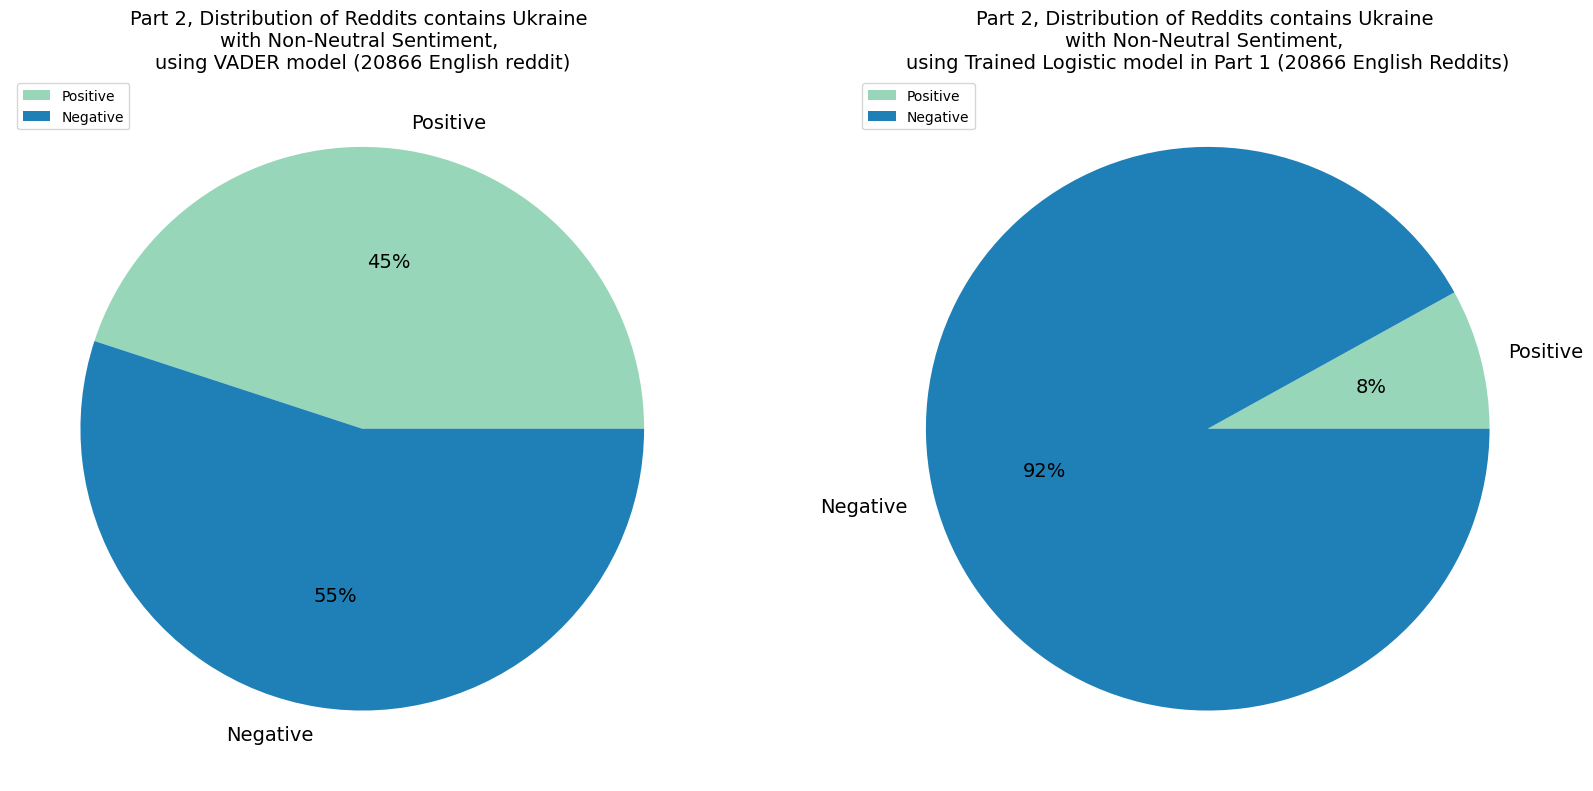

In [116]:
df_plot4 = df_ukraine['vadar_label'].value_counts(ascending = True).to_frame()
df_plot5 = df_ukraine['lr_predicted_label'].value_counts(ascending = True).to_frame()
df_plot4.rename(index ={'neg': 'Negative', 'pos': 'Positive'}, inplace = True)
df_plot5.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot4.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Reddits contains Ukraine \nwith Non-Neutral Sentiment, \nusing VADER model (%s English reddit)'%len(df_ukraine['vadar_label']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot5.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Reddits contains Ukraine \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Reddits)'%len(df_ukraine['lr_predicted_label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

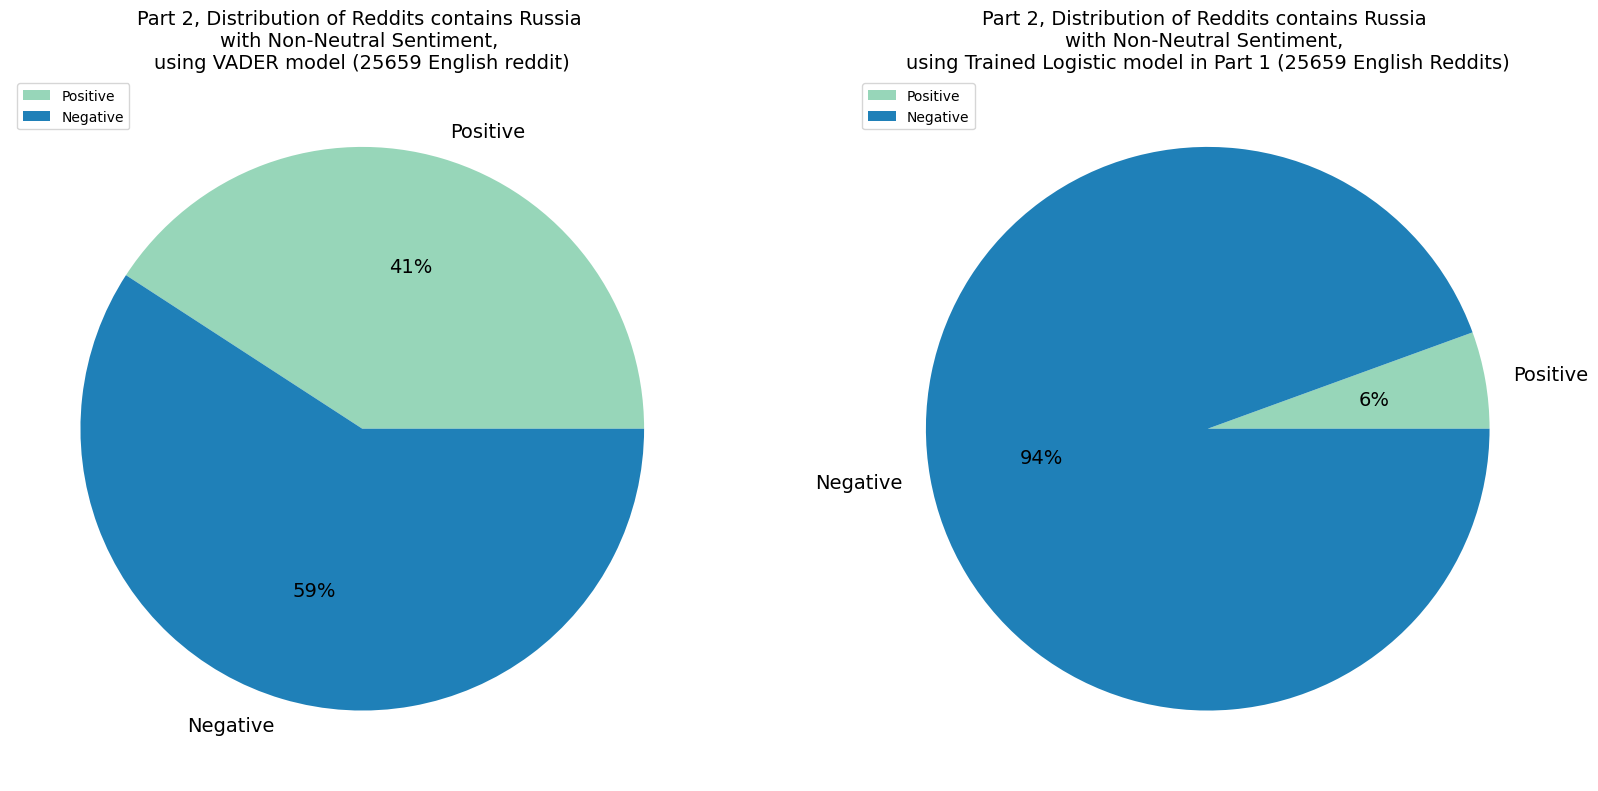

In [117]:
df_plot6 = df_russia['vadar_label'].value_counts(ascending = True).to_frame()
df_plot7 = df_russia['lr_predicted_label'].value_counts(ascending = True).to_frame()
df_plot6.rename(index ={'neg': 'Negative', 'pos': 'Positive'}, inplace = True)
df_plot7.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot6.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Reddits contains Russia \nwith Non-Neutral Sentiment, \nusing VADER model (%s English reddit)'%len(df_russia['vadar_label']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot7.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Reddits contains Russia \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Reddits)'%len(df_russia['lr_predicted_label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

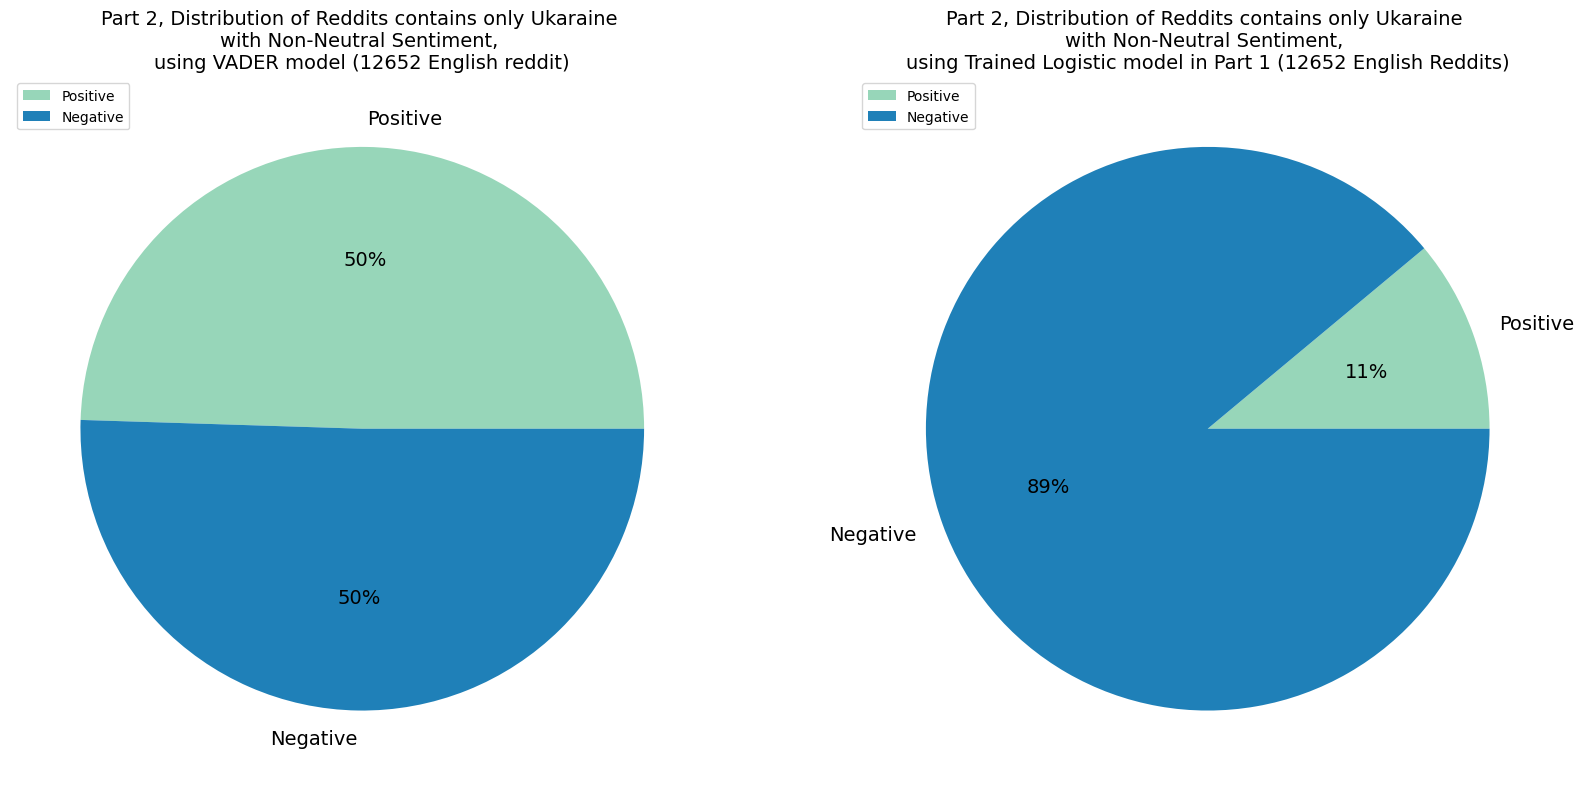

In [118]:
df_plot8 = df_ukraine_only['vadar_label'].value_counts(ascending = True).to_frame()
df_plot9 = df_ukraine_only['lr_predicted_label'].value_counts(ascending = True).to_frame()
df_plot8.rename(index ={'neg': 'Negative', 'pos': 'Positive'}, inplace = True)
df_plot9.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot8.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Reddits contains only Ukaraine \nwith Non-Neutral Sentiment, \nusing VADER model (%s English reddit)'%len(df_ukraine_only['vadar_label']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot9.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Reddits contains only Ukaraine \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Reddits)'%len(df_ukraine_only['lr_predicted_label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

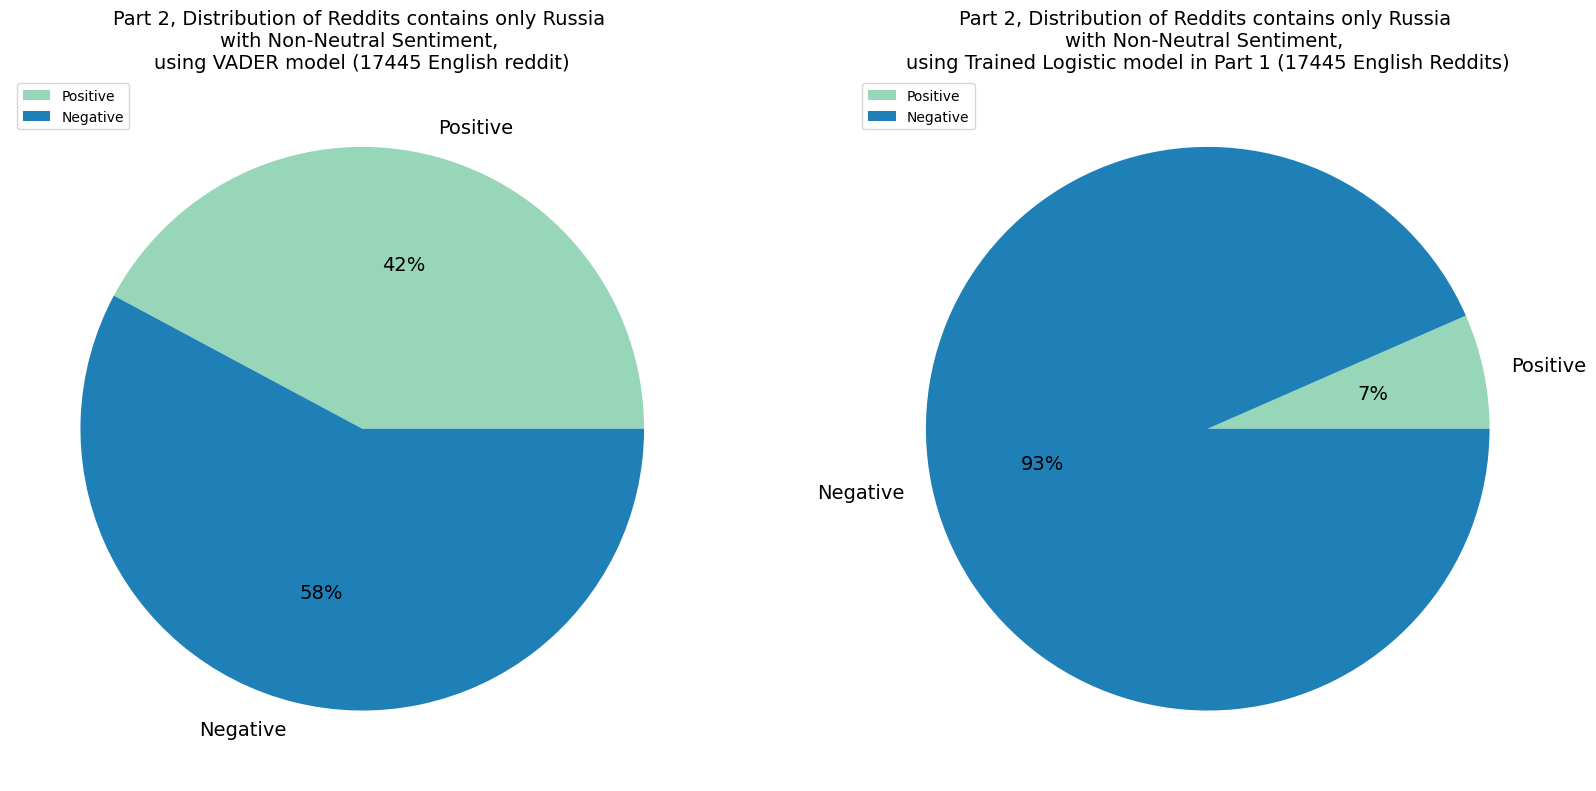

In [119]:
df_plot10 = df_russia_only['vadar_label'].value_counts(ascending = True).to_frame()
df_plot11 = df_russia_only['lr_predicted_label'].value_counts(ascending = True).to_frame()
df_plot10.rename(index ={'neg': 'Negative', 'pos': 'Positive'}, inplace = True)
df_plot11.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot10.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Reddits contains only Russia \nwith Non-Neutral Sentiment, \nusing VADER model (%s English reddit)'%len(df_russia_only['vadar_label']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot11.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Reddits contains only Russia \nwith Non-Neutral Sentiment, \nusing Trained Logistic model in Part 1 (%s English Reddits)'%len(df_russia_only['lr_predicted_label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

## **Part 3 Factor and topics identification via Machine Learning**

## 3.1 Tweet Data

### 3.1.1 Split the dataset

In [120]:
data_labeled = pd.read_csv("non-neutral tweets labeled using vader and lg.csv")

In [121]:
data_labeled

Unnamed: 0   index language  \
0                0       1       en   
1                1       2       en   
2                2       4       en   
3                3       5       en   
4                5       7       en   
...            ...     ...      ...   
340067      412220  184245       en   
340068      412221  184247       en   
340069      412222  184248       en   
340070      412223  184250       en   
340071      412225  184252       en   

                                                     text  \
0       online class homework , assignment exam help e...   
1       british intelligence ukrainerussiawar map mar ...   
2       learn love prosper video ! russianwarcrimes uk...   
3       usa -the pentagon plan increase spending cyber...   
4       russia ’ combat loss ukrainewar front includin...   
...                                                   ...   
340067  ukrainian child destined experience horror war...   
340068  ukrainian soldier bakhmut , house house fighti...   
340069  poland slovakia jointly transfer 33 mig-29 fig...   
340070  russia syria assad ukraine zelenskywarcriminal...   
340071  nail coffin russian troopsukraine war video fo...   

                                                 hashtags  \
0       [{'text': 'USA', 'indices': [141, 145]}, {'tex...   
1       [{'text': 'UkraineRussiaWar', 'indices': [21, ...   
2       [{'text': 'RussianWarCrimes', 'indices': [69, ...   
3       [{'text': 'USA', 'indices': [0, 4]}, {'text': ...   
4       [{'text': 'UkraineWar', 'indices': [26, 37]}, ...   
...                                                   ...   
340067  [{'text': 'Russia', 'indices': [107, 114]}, {'...   
340068  [{'text': 'Bakhmut', 'indices': [23, 31]}, {'t...   
340069  [{'text': 'Poland', 'indices': [84, 91]}, {'te...   
340070  [{'text': 'Russia', 'indices': [0, 7]}, {'text...   
340071  [{'text': 'Canada', 'indices': [68, 75]}, {'te...   

        p1 best model label VADER Sentiment  VADER Label  binary ukraine  \
0                         0        Positive            1               0   
1                         0        Positive            1               0   
2                         1        Positive            1               1   
3                         0        Positive            1               0   
4                         0        Negative            0               1   
...                     ...             ...          ...             ...   
340067                    0        Negative            0               0   
340068                    0        Negative            0               0   
340069                    1        Positive            1               1   
340070                    0        Negative            0               1   
340071                    0        Negative            0               1   

        binary russia  binary russia only  binary ukraine only  
0                   0                   0                    0  
1                   0                   0                    0  
2                   0                   0                    1  
3                   0                   0                    0  
4                   1                   0                    0  
...               ...                 ...                  ...  
340067              1                   1                    0  
340068              0                   0                    0  
340069              0                   0                    1  
340070              1                   0                    0  
340071              0                   0                    1  

[340072 rows x 12 columns]

In [122]:
df_n = data_labeled[data_labeled["VADER Label"] == 0]
df_p = data_labeled[data_labeled["VADER Label"] == 1]

### 3.1.1 Topics for negative sentiment data

In [123]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
doc_term_matrix = count_vect.fit_transform(df_n['text'].values.astype('U'))

In [124]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=10, random_state=8)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(random_state=8)

In [125]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-80:]])
    print('\n')

Top 10 words for topic #0:
['trying', 'fight', 'making', 'nazi', 'history', 'know', 'fake', 'impact', 'number', 'minister', 'assad', 'israel', 'come', 'point', 'international', 'peace', 'new', 'end', 'family', 'leader', 'nuclear', 'today', 'press', 'cut', 'way', 'nation', 'plan', 'conflict', 'news', 'ago', 'visit', 'terrorist', 'crime', 'invasion', 'make', 'law', 'based', 'chinese', 'death', 'sanction', 'like', 'foreign', 'turkey', 'state', 'crisis', 'say', 'start', 'syria', 'poland', 'crimea', 'military', 'stop', 'oil', 'west', 'regime', 'said', 'pay', 'moscow', 'europe', 'ukrainerussiawar', 'want', 'iran', 'weapon', 'usa', 'need', 'russian', 'western', 'eu', 'people', 'time', 'year', 'china', 'world', 'amp', 'country', 'nato', 'putin', 'war', 'ukraine', 'russia']


Top 10 words for topic #1:
['security', 'australia', 'hacked', 'army', 'diplomacy', 'covid', 'eritrea', 'gt', 'lower', 'influence', 'goodnight', 'genius', 'wounded', 'line', 'police', 'position', 'shortly', 'work', 'fighti

In [126]:
topic_values = LDA.transform(doc_term_matrix)
df_n['topics'] = topic_values.argmax(axis = 1)

In [127]:
#define each topic
topics_num = {0:'invasion', 1:'destruction', 2:'killing', 3:'putin, mass killer', 4:'pain for children', 5:"air assualt",
              6:'international aid', 7:'crimes against humanity', 8:'crisis', 9:"explosion"}
#Map the topic name 
df_n['topic name'] = df_n['topics'].map(topics_num)
df_n['topic name']

4                     air assualt
10        crimes against humanity
13                    air assualt
14                       invasion
15                       invasion
                   ...           
340066          international aid
340067                    killing
340068                air assualt
340070                    killing
340071                air assualt
Name: topic name, Length: 191104, dtype: object

In [128]:
df_n_count = pd.DataFrame(df_n['topic name'].value_counts())

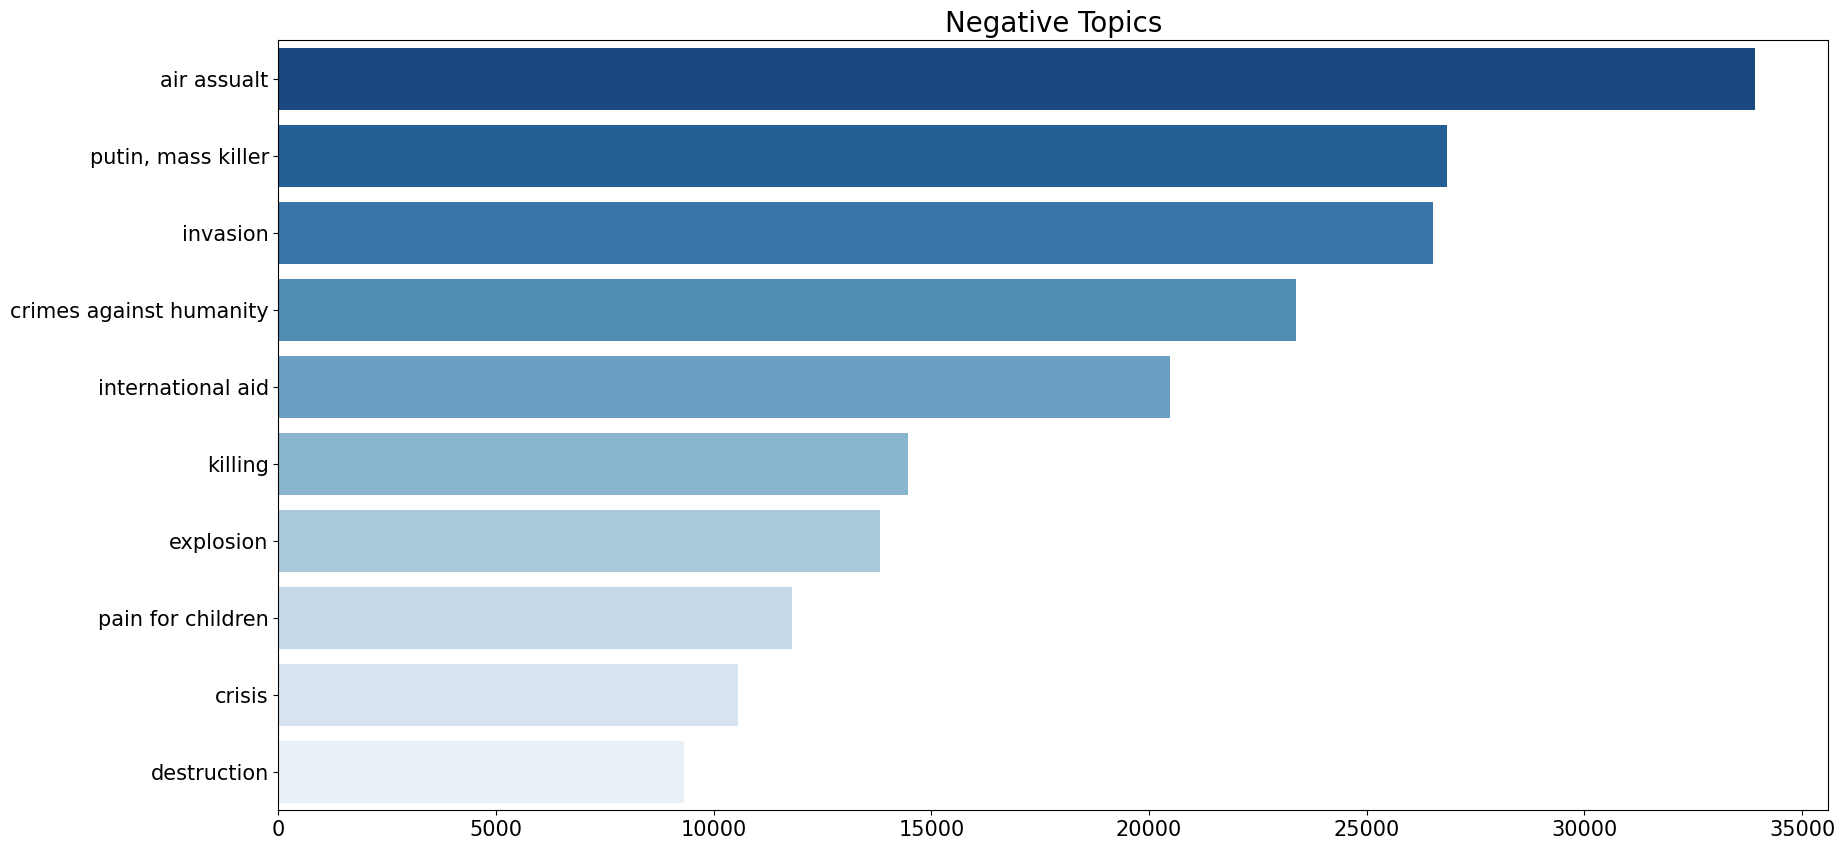

In [129]:
import seaborn as sns
plt.figure(figsize=(20,10))
    
plot = sns.barplot(x = df_n_count.iloc[:,0].values, y = df_n_count.index.tolist(), palette="Blues_r", orient = 'h')
plot.set_title('Negative Topics',fontsize =20) 
plt.xticks(rotation='horizontal', fontsize =15)
plt.yticks(rotation='horizontal', fontsize =15)
plt.show()

### 3.1.2 Topics for positive sentiment data

In [130]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
doc_term_matrix = count_vect.fit_transform(df_p['text'].values.astype('U'))

In [131]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [132]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-50:]])
    print('\n')

Top 10 words for topic #0:
['war', 'sport', 'live', 'body', 'supporting', 'iraq', 'child', 'china', 'soldier', 'eu', 'standwithukraine', 'day', 'anniversary', 'need', 'joke', 'far', 'country', 'use', 'thank', 'used', 'state', 'good', 'kind', 'support', 'best', 'say', 'year', 'russiaisaterroriststate', 'freedom', 'invasion', 'issue', 'ukrainewar', 'warrant', 'leader', 'america', 'amp', 'peace', 'like', 'ukrainerussianwar', 'trump', 'time', 'president', 'nato', 'world', 'icc', 'ukrainian', 'russian', 'putin', 'russia', 'ukraine']


Top 10 words for topic #1:
['send', 'ukrainewillwin', 'day', 'peace', 'hero', 'good', 'visit', 'win', 'news', 'ukrainerussiawar', 'justice', 'outdated', 'burglar', 'illogical', 'jeffsonnenfeld', 'mockery', 'sergiykyslytsya', 'region', 'fool', 'need', 'manager', 'presidency', 'given', 'love', 'great', 'standwithukraine', 'free', 'council', 'defend', 'making', 'april', 'bank', 'wo', 'month', 'bakhmut', 'security', 'uk', 'force', 'germany', 'like', 'putin', 'peop

In [133]:
topic_values = LDA.transform(doc_term_matrix)
df_p['topics'] = topic_values.argmax(axis = 1)

In [134]:
#define each topic
topics_num = {0:'Kind support from other countries', 1:'Hope for peace', 2:'Help from NATO', 3:'Surge nationalism', 4:'Bravery and resilience of Ukrainians'}
#Map the topic name 
df_p['topic name'] = df_p['topics'].map(topics_num)
df_p['topic name']

0                               Help from NATO
1                               Help from NATO
2                               Hope for peace
3            Kind support from other countries
5                               Hope for peace
                          ...                 
340049                          Hope for peace
340053       Kind support from other countries
340055       Kind support from other countries
340061       Kind support from other countries
340069    Bravery and resilience of Ukrainians
Name: topic name, Length: 148968, dtype: object

In [135]:
df_p_count = pd.DataFrame(df_p['topic name'].value_counts())

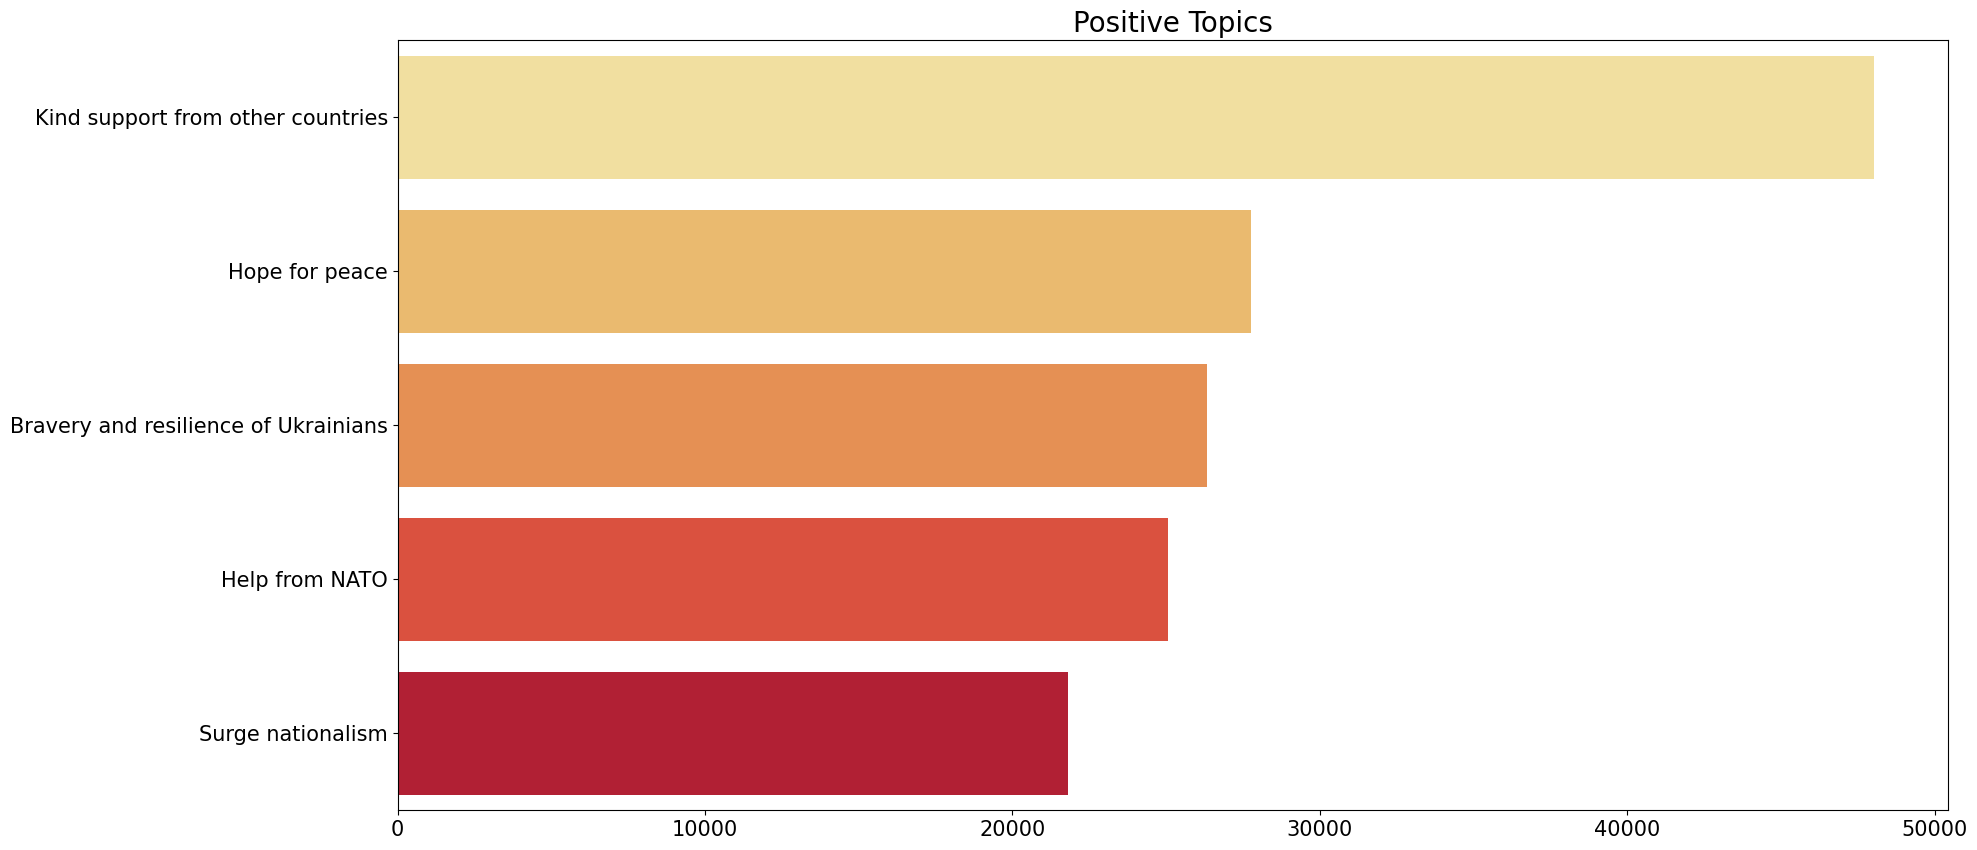

In [136]:
import seaborn as sns
plt.figure(figsize=(20,10))
    
plot = sns.barplot(x = df_p_count.iloc[:,0].values, y = df_p_count.index.tolist(), palette="YlOrRd", orient = 'h')
plot.set_title('Positive Topics',fontsize =20) 
plt.xticks(rotation='horizontal',fontsize =15)
plt.yticks(rotation='horizontal',fontsize =15)
plt.show()

## 3.2 Reddit Data

### 3.2.1 Split the dataset

In [137]:
data_labeled_reddit = pd.read_csv("/labeled_reddit_p2.csv")

In [138]:
data_labeled_reddit

comments  lr_predicted_label  \
0       told , barbarian already , event notwithstandi...                   0   
1                      oh . decathlon bad ? ordered them…                   0   
2       last read commited almost combat ground force ...                   0   
3       lukashenko already president… . protest people...                   0   
4                                                russia :                   0   
...                                                   ...                 ...   
200228  doubt city major city put iron spine , ’ impor...                   0   
200229  except china ’ country . hand many cookie jar ...                   0   
200230                                 ’ shitting before…                   0   
200231  tl : mariupol , temporarily captured invader ,...                   0   
200232  `` shall fight beach , shall fight landing gro...                   0   

        compound vadar_label  
0         0.0000         neu  
1        -0.5423         neg  
2        -0.2748         neg  
3         0.8658         pos  
4         0.0000         neu  
...          ...         ...  
200228   -0.5994         neg  
200229    0.2732         pos  
200230   -0.4215         neg  
200231    0.9148         pos  
200232   -0.8555         neg  

[200233 rows x 4 columns]

In [139]:
df_n_r = data_labeled_reddit[data_labeled_reddit["vadar_label"] == "neg"]
df_p_r = data_labeled_reddit[data_labeled_reddit["vadar_label"] == "pos"]

### 3.2.2 Topics for negative sentiment data

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
doc_term_matrix = count_vect.fit_transform(df_n_r['comments'].values.astype('U'))

In [141]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=6, random_state=8)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=6, random_state=8)

In [142]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 6 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-80:]])
    print('\n')

Top 6 words for topic #0:
['population', 'new', 'invasion', 'energy', 'lost', 'start', 'point', 'america', 'say', 'buy', 'decade', 'threat', 'usa', 'reason', 'good', 'said', 'economic', 'ally', 'putin', 'aid', 'france', 'ca', 'billion', 'price', 'american', 'actually', 'really', 'lot', 'support', 'right', 'poland', 'million', 'european', 'help', 'long', 'nation', 'mean', 'know', 'conflict', 'western', 'end', 'pay', 'nuclear', 'stop', 'state', 'thing', 'economy', 'power', 'weapon', 'problem', 'going', 'way', 'government', 'india', 'west', 'sanction', 'think', 'want', 'like', 'oil', 'german', 'money', 'eu', 'need', 'make', 'europe', 'military', 'gas', 'nato', 'time', 'people', 'world', 'year', 'russian', 'china', 'germany', 'country', 'ukraine', 'war', 'russia']


Top 6 words for topic #1:
['border', 'crimea', 'launch', 'sure', 'tactical', 'supply', 'capability', 'able', 'actually', 'ca', 'western', 'fight', 'likely', 'modern', 'ground', 'start', 'loss', 'probably', 'destroy', 'ship', 'n

In [143]:
topic_values = LDA.transform(doc_term_matrix)
df_n_r['topics'] = topic_values.argmax(axis = 1)

In [144]:
#define each topic
topics_num = {0:'invasion', 1:'destruction', 2:'killing', 3:'military', 4:'putin', 5:"nazi"}
#Map the topic name 
df_n_r['topic name'] = df_n_r['topics'].map(topics_num)
df_n_r['topic name']

1             killing
2            military
7                nazi
8                nazi
11               nazi
             ...     
200219           nazi
200224    destruction
200228       military
200230        killing
200232       military
Name: topic name, Length: 75178, dtype: object

In [145]:
df_n_count = pd.DataFrame(df_n_r['topic name'].value_counts())

In [146]:
df_n_count

topic name
nazi              19225
killing           14383
invasion          13789
destruction       13101
military           8223
putin              6457

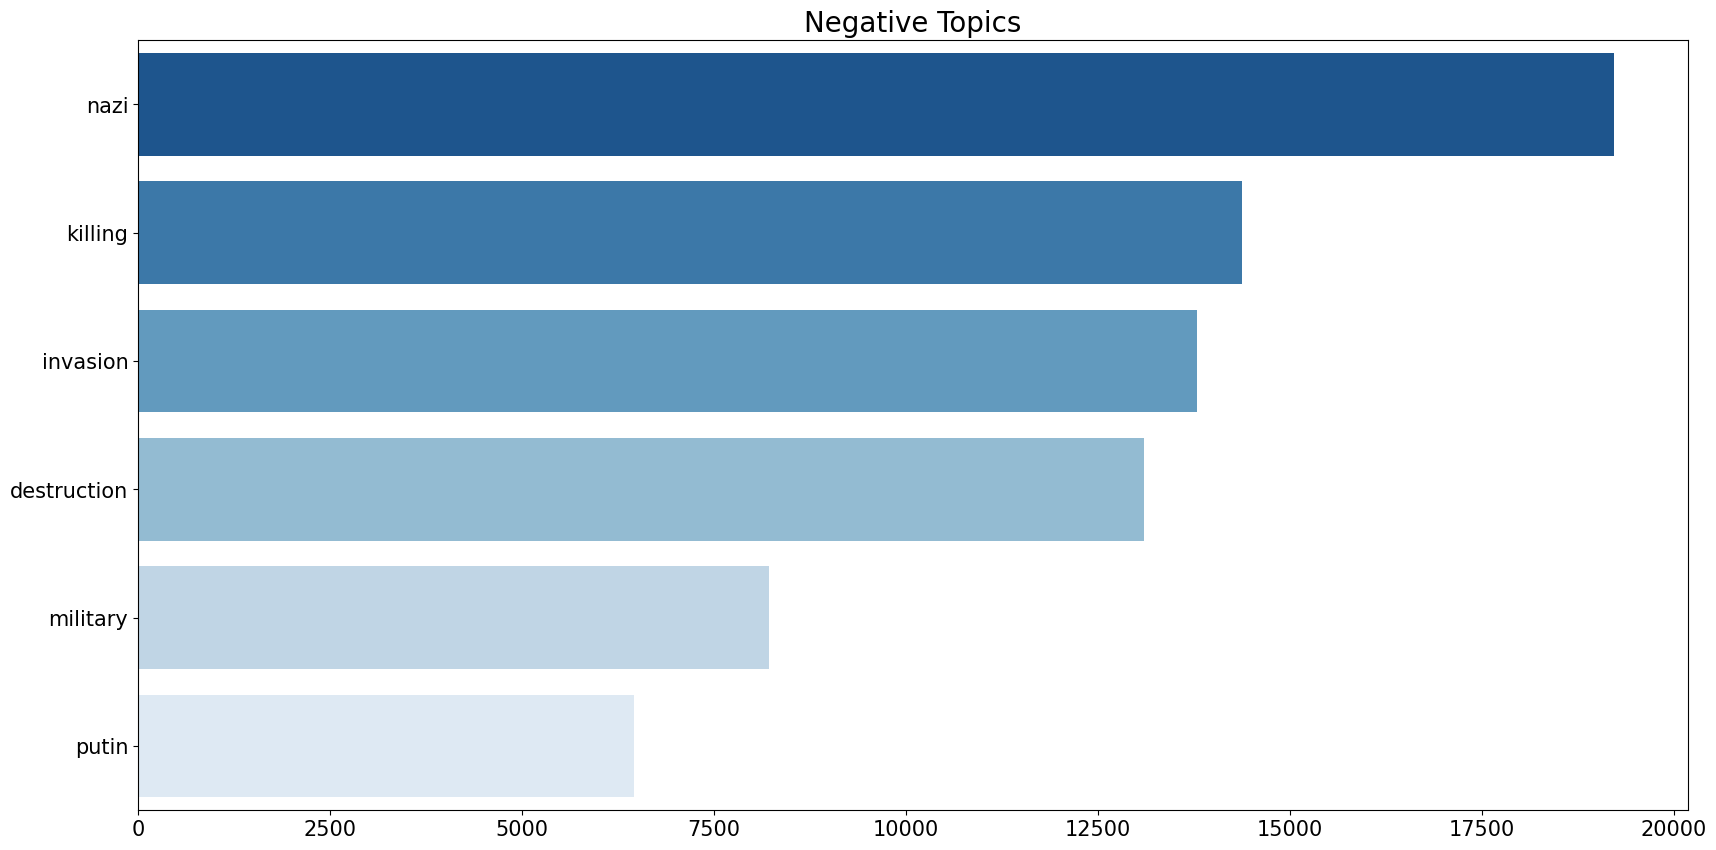

In [147]:
import seaborn as sns
plt.figure(figsize=(20,10))
    
plot = sns.barplot(x = df_n_count.iloc[:,0].values, y = df_n_count.index.tolist(), palette="Blues_r", orient = 'h')
plot.set_title('Negative Topics',fontsize =20) 
plt.xticks(rotation='horizontal', fontsize =15)
plt.yticks(rotation='horizontal', fontsize =15)
plt.show()

### 3.2.3 Topics for positive sentiment data

In [148]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
doc_term_matrix = count_vect.fit_transform(df_p_r['comments'].values.astype('U'))

In [149]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [150]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-50:]])
    print('\n')

Top 10 words for topic #0:
['lot', 'year', 'energy', 'mean', 'point', 'crimea', 'western', 'troop', 'use', 'territory', 'know', 'turkey', 'long', 'really', 'border', 'support', 'best', 'europe', 'germany', 'sure', 'help', 'gas', 'way', 'eu', 'state', 'weapon', 'west', 'yes', 'nuke', 'world', 'power', 'time', 'make', 'china', 'nuclear', 'force', 'war', 'ukrainian', 'like', 'think', 'going', 'putin', 'need', 'want', 'military', 'country', 'nato', 'russian', 'ukraine', 'russia']


Top 10 words for topic #1:
['open', 'germany', 'day', 'spelling', 'happy', 'll', 'want', 'kyiv', 'using', 'hope', 'new', 'nice', 'need', 'amp', 'thought', 'page', 'ukrainian', 'sorry', 'better', 'help', 'think', 'instead', 'nazi', 'friend', 'check', 'know', 'way', 'ok', 'israel', 'good', 'look', 'operation', 'thank', 'lmao', 'time', 'maybe', 'support', 'special', 'great', 'gon', 'sure', 'na', 'said', 'putin', 'russian', 'like', 'russia', 'thanks', 'lol', 'ukraine']


Top 10 words for topic #2:
['hi', 'removed', 

In [151]:
topic_values = LDA.transform(doc_term_matrix)
df_p_r['topics'] = topic_values.argmax(axis = 1)

In [152]:
#define each topic
topics_num = {0:'Help', 1:'Hope for peace', 2:'Effort of Ukrainians', 3:'Support', 4:'Bravery and resilience of Ukrainians'}
#Map the topic name 
df_p_r['topic name'] = df_p_r['topics'].map(topics_num)
df_p_r['topic name']

3                                      Support
5                                         Help
6                                         Help
10        Bravery and resilience of Ukrainians
12                              Hope for peace
                          ...                 
200223                                 Support
200225                          Hope for peace
200226                                 Support
200229                                    Help
200231                          Hope for peace
Name: topic name, Length: 78619, dtype: object

In [153]:
df_p_count = pd.DataFrame(df_p_r['topic name'].value_counts())

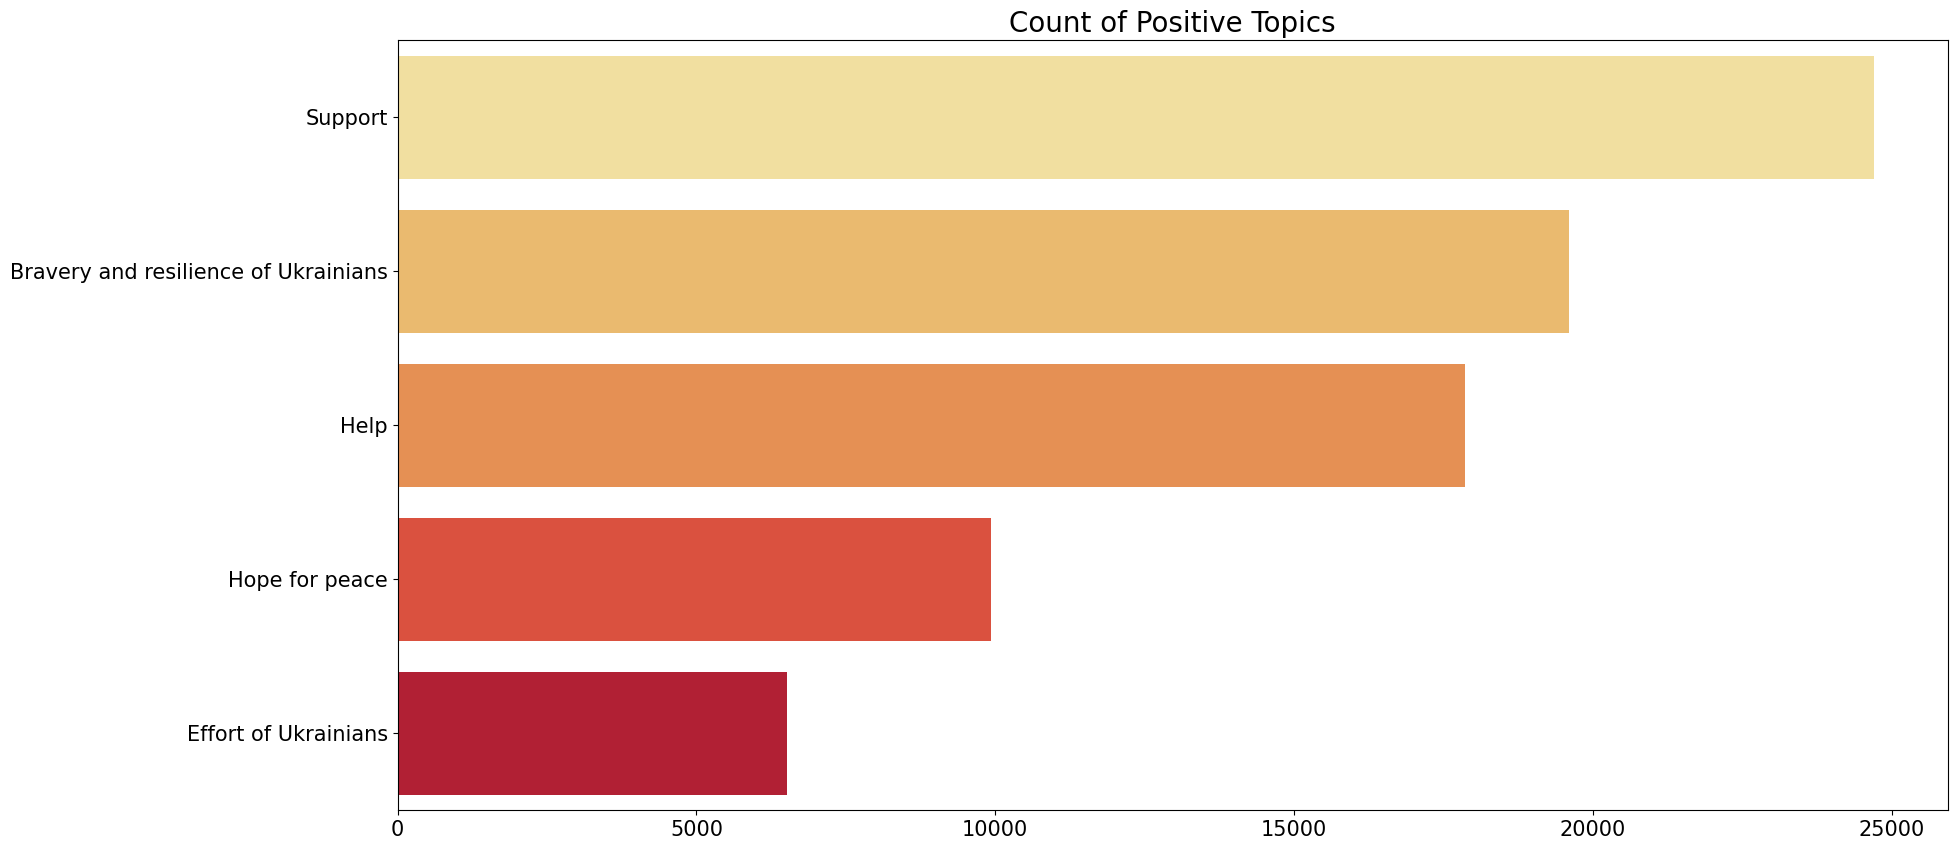

In [154]:
import seaborn as sns
plt.figure(figsize=(20,10))
    
plot = sns.barplot(x = df_p_count.iloc[:,0].values, y = df_p_count.index.tolist(), palette="YlOrRd", orient = 'h')
plot.set_title('Count of Positive Topics',fontsize =20) 
plt.xticks(rotation='horizontal',fontsize =15)
plt.yticks(rotation='horizontal',fontsize =15)
plt.show()

### WordCloud for Tweet and Reddit comment

In [155]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


stop_words = set(stopwords.words('english'))

def get_keywords(comments):
    words = []
    for comment in comments:
        tokens = word_tokenize(comment)
        for token in tokens:
            if token.lower() not in stop_words and token.isalpha():
                words.append(token.lower())
    return words


positive_words = set(get_keywords(df_p['text']))
negative_words = set(get_keywords(df_n['text']))

common_words = positive_words.intersection(negative_words)

print("Common keywords:")
print(common_words)

Common keywords:
{'settlement', 'protesting', 'deceased', 'dji', 'formidable', 'selecting', 'hodgetwins', 'wilson', 'murdoch', 'beet', 'freepalestine', 'britain', 'aiannucci', 'feeding', 'sincerely', 'unreal', 'island', 'resigned', 'cola', 'wrote', 'melaniejoly', 'ifrc', 'cad', 'indian', 'amandacdonegan', 'purposefully', 'therecount', 'prostitution', 'socialism', 'colonized', 'precarious', 'mhealth', 'nycacc', 'depart', 'documentary', 'norman', 'trumpindictment', 'soldier', 'misunderstanding', 'render', 'blablabla', 'sinophobia', 'bday', 'ahmedabad', 'mri', 'temporaryprotection', 'lane', 'nt', 'stork', 'lnpcorruptionparty', 'watkins', 'admiration', 'destroyer', 'acl', 'natoexpansion', 'basharassad', 'persecutor', 'gunshot', 'tymofiy', 'heel', 'adoption', 'crim', 'ryabkov', 'belbek', 'docnickie', 'pevchikh', 'fantastical', 'snow', 'suspending', 'fancy', 'prayforukraine', 'bscgems', 'brig', 'ascent', 'undercover', 'gatewaypundit', 'lnr', 'obliged', 'interferes', 'provocateur', 'friendly'

(-0.5, 399.5, 199.5, -0.5)

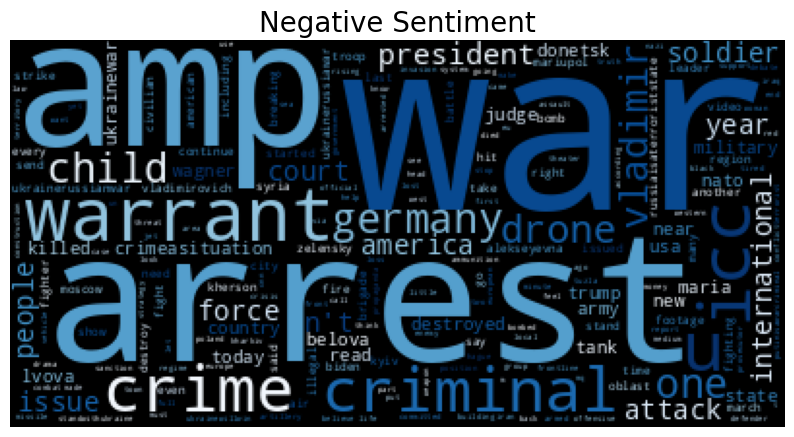

In [156]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(df_n['text'].values))

stopwords = set(STOPWORDS)
stopwords.update(["ukraine","ukrainian","russian","russia","putin","canada","china","world","day","bakhmut","s"])

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stopwords, collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap='Blues_r')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.title("Negative Sentiment for Tweet", fontsize= 20)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

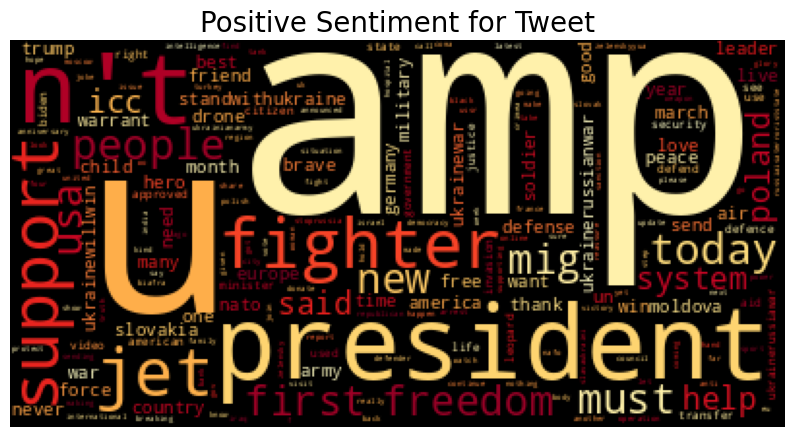

In [158]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_p['text'].values))

# Create a WordCloud object
wordcloud1 = WordCloud(stopwords = stopwords, collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap = 'YlOrRd')

# Generate a word cloud
wordcloud1.generate(long_string)

# Visualize the word cloud
wordcloud1.to_image()
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1)
plt.title("Positive Sentiment for Tweet", fontsize= 20)
plt.axis("off")

In [159]:
positive_words = set(get_keywords(df_p_r['comments']))
negative_words = set(get_keywords(df_n_r['comments']))

common_words = positive_words.intersection(negative_words)

print("Common keywords:")
print(common_words)

Common keywords:
{'settlement', 'ukrianes', 'protesting', 'deceased', 'overweight', 'dji', 'selecting', 'formidable', 'stoop', 'wilson', 'murdoch', 'beet', 'grandad', 'britain', 'feeding', 'sincerely', 'phosphate', 'ldnr', 'nutrition', 'island', 'unreal', 'resigned', 'cola', 'wrote', 'ifrc', 'assaulting', 'cad', 'indian', 'purposefully', 'prostitution', 'socialism', 'colonized', 'precarious', 'depart', 'documentary', 'headlining', 'norman', 'soldier', 'misunderstanding', 'render', 'consumerism', 'blablabla', 'ensued', 'mri', 'gunnery', 'lane', 'nt', 'cholesterol', 'defensively', 'admiration', 'destroyer', 'gunshot', 'tymofiy', 'heel', 'adoption', 'terrorize', 'starlinks', 'ez', 'belbek', 'marcon', 'gangbanged', 'fantastical', 'aquire', 'snow', 'tyva', 'suspending', 'kmw', 'fancy', 'brig', 'undercover', 'lnr', 'obliged', 'interferes', 'overseen', 'interesse', 'allusion', 'provocateur', 'elicit', 'friendly', 'musk', 'forge', 'even', 'hypnosis', 'dissapear', 'aswell', 'retelling', 'dined'

(-0.5, 399.5, 199.5, -0.5)

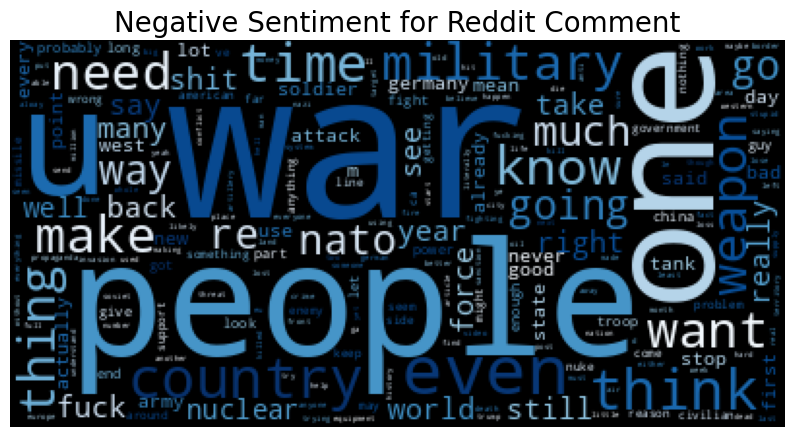

In [166]:
long_string = ','.join(list(df_n_r['comments'].values))

stopwords = set(STOPWORDS)
stopwords.update(["ukraine","ukrainian","russian","russia","putin","s", "n't"])

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stopwords, collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap='Blues_r')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.title("Negative Sentiment for Reddit Comment", fontsize= 20)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

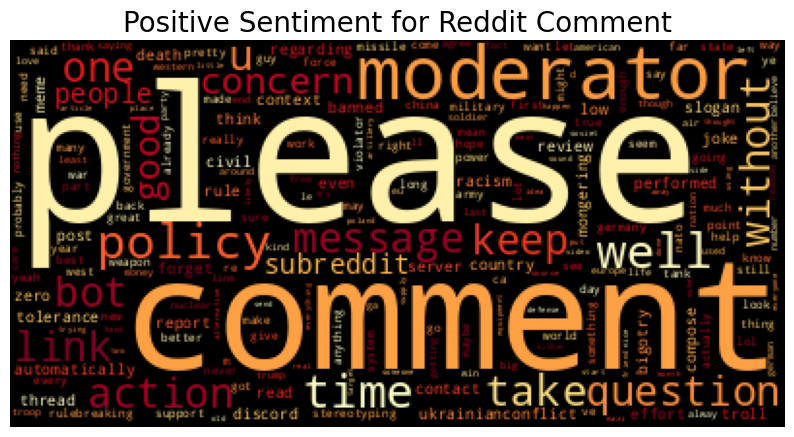

In [167]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_p_r['comments'].values))

# Create a WordCloud object
wordcloud1 = WordCloud(stopwords = stopwords, collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap = 'YlOrRd')

# Generate a word cloud
wordcloud1.generate(long_string)

# Visualize the word cloud
wordcloud1.to_image()
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1)
plt.title("Positive Sentiment for Reddit Comment", fontsize= 20)
plt.axis("off")

In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb